# Apply AI Superresolution to video - Train VDSR from Video Frames

## Use a perception loss
https://github.com/richzhang/PerceptualSimilarity

 

# Get a video dataset to do better training
- higher resolution than used in research

### super 8 look https://www.youtube.com/watch?v=7Q5UZmwxIXo
- low focus (diffusion and blur - bokah)
- low contrast
- camera is more shakey on home movies
- high depth of field everything is sharp
- 4x3
- film grain
- color changes
- mpeg2 compression noise

### VCR look
- jitter on scan lines - see http://www.avisynth.nl/users/vcmohan/DeJitter/DeJitter.htm
- chroma issues https://forum.videohelp.com/threads/397928-Imrpove-old-video-recorded-by-a-bad-camera?s=0a1230911434e7442d05b6b6cee8e6d2

- jpeg compression artifacts

## use images of related material to train superres
- family photos to train for family videos
- need water and outdoors
- use video samples for video
- use film examples for super8

## Data Augmentation
- sample a few frames from a few places - complete
- different blur levels- complete
- different blur levels in the same image - complete
- convolution with disk - complete
- left-right flip - complete
- contrast and brightness - complete
- random crop - use center crop
- crop to the super8 resolution 720x480 or video 320x240 - complete
- GAN statistics
- predict level of blur with same network to encourage differentiation to that
- input of a filter that detects light reflections to help infer blurring
- try mixup
- use a single shot classifier output as an input

- see this library for blending images https://pypi.org/project/blend-modes/


## Optimization
- Use Adam - complete
- Use optimal learning rate
- freeze layers
- dropout
- use fp16 - pytorch1.6 has a new library for this - complete
- train on low res and increase resolution - does not seem to help in convergence

## losses
- try l1 loss - does not converge
- try perceptive loss vgg18 - complete
- perceptive loss uses 256x256 images - too low res, so use overlapping subsets of image to calc loss
- combine perceptive and mse loss
- calculate mse loss on a smoothed version of output compared to input (which is smoothed) - ensure reversal matches


## do comparisons for standard test sets
- not super useful since they use gaussian blurring, bicubic interpolation
- get very focused images and use as a validation and test set - prefer one thats published


## Results & Analysis
- Fixes - jpeg artifacts were fixed at one level 30 and slope at 0.01 in:
Superresolution train vdsr with multifuz
Superresolution train vdsr with perception loss multifuz

- mse only goes so far.  too strict
- Perceptual loss helps improve it, but input is 256x256 resolution so limited sharpness.
- Perceptual loss tiled (hires) causes too much causes artifacts
- multifuz improves results especially with perceptual loss, handles different fuzziness better

Next experiment
- training may not need to go as long - complete
- set kernel range from 1 to 20 - vs 4-20 need lower range too - complete
- combination of hi res perceptual and mse on smoothed versions of input.- complete
- give more emphasis to mse

Other ideas
- train on cleaner images div8K
- cascade 2 models.  Train first as usual.  Use it to preprocess input to train second model
- apply mix-up
- better model and apply to all 3 colors
- try vgg perception metric
- focus prediction


RCAN Results
- Uses lots of resources as scale of image increases
- Does not handle different scales well
- not meant for restoration - 
To try
- Apply pretrained model on a patch thats 48x48 then can judge if its worth making an approach to apply repeatedly to larger images.
- train vdsr with a convolutional upscaling up front, attention, residuals.






## Share results
- put out an example on youtube to allow comparison


# Project Documentation

In [1]:

from pathlib import Path
import os


project_base = "/media/SSD/superres/"
results_folder = "Results"
data_folder = "video_data"
model_folder = "checkpoint"

model_name_base = "EDSR"


## Experiment documentation

In [2]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [3]:
print("NOTEBOOK_FULL_PATH:\n", NOTEBOOK_FULL_PATH)

NOTEBOOK_FULL_PATH:
 /SSD_link/superres/Superresolution train vdsr with hres perception loss multifuz-3.ipynb


In [4]:
nb_path = Path(NOTEBOOK_FULL_PATH)
print(nb_path)

# Make result folder if it does not exist
result_path = Path(project_base, results_folder , nb_path.stem )
print(result_path)
os.makedirs(result_path, exist_ok=True)

/SSD_link/superres/Superresolution train vdsr with hres perception loss multifuz-3.ipynb
/media/SSD/superres/Results/Superresolution train vdsr with hres perception loss multifuz-3


In [5]:
model_out_path=Path(project_base)/model_folder
print(model_out_path)
os.makedirs(model_out_path, exist_ok=True)

/media/SSD/superres/checkpoint


In [6]:
# Tie a result to a set of params.  Tie a set of params to a model.  Tie a model to a notebook.
# register the experiment to get a unique run id
# save all the results in a repository
# use github to do it?

In [7]:

#%reload_ext autoreload
#%autoreload 2
#%matplotlib inline


import cv2 
import numpy as np
import subprocess as sp
import time
from tqdm import tqdm, trange
import torch
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from torchvision.transforms import RandomHorizontalFlip,ColorJitter
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize, Grayscale,ToPILImage

import random
from astropy.convolution import  Gaussian2DKernel, Tophat2DKernel,AiryDisk2DKernel


import sys
sys.path.insert(0, '/media/SSD/superres/pytorch-vdsr/')

#from vdsr import Net

import lpips #https://github.com/richzhang/PerceptualSimilarity

In [8]:
import torch.utils.data as data

from os import listdir
from os.path import join
from PIL import Image, ImageFilter
import numpy as np
import torchvision as vision

import numbers


torch.cuda.manual_seed(42)

Create a data loader
- see https://github.com/2KangHo/vdsr_pytorch/blob/master/data.py
- see https://github.com/2KangHo/vdsr_pytorch/blob/master/data_utils.py

In [9]:



toPIL = vision.transforms.ToPILImage()


def noisy(img, std=3.0):
    mean = 0.0
    gauss = np.random.normal(mean, std, (img.height, img.width, 3))
    # noisy = np.clip(np.uint8(img + gauss), 0, 255)
    noisy = np.uint8(img + gauss)
    return noisy


def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg", ".bmp"])



In [10]:
def is_video_file(path, extensions = ("mp4",)):
    return path.lower().endswith(extensions)

def frame_sampler1(length, frame_sample_size):

    # calculate middle of video and take 'frame_sample_size' frames from middle
    middle = length // 2
    left_length = frame_sample_size//2
    right_length = frame_sample_size - left_length
    left = max(0,middle - left_length)
    right = min(length, middle + right_length)
          
    return list(range(left,right))



def frame_sampler2(length, frame_sample_size):
    return np.linspace(0, length, 3+min(frame_sample_size,length)).astype(int)[2:-1]


# Make this load still photos too, and have them added with frame = 0
def make_framelist(video_dir,frame_sample_size = 10):
    instances = []
    for filename in listdir(video_dir):
        filepath = os.path.join(video_dir,filename)
        #print(filename)
        
        if is_video_file(filepath):
            # open video file
            cap = cv2.VideoCapture(str(filepath))

            # get frame count
            length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

            cap.release()
            
            if frame_sample_size is not None:
                samples = frame_sampler2(length, frame_sample_size)
                # append fn and frame num to instances
            else:
                samples = range(0,length)
                
            for frame in samples:
                item = {"Filepath":filepath,"Type":"frame",  "Framenum":frame}
                instances.append(item)
                
        elif is_image_file(filepath):
            # open image file
            img = cv2.imread(filepath)
            item = {"Filepath":filepath, "Type":"image"}
            instances.append(item)
            
    return instances
        

In [11]:
# get a list of all the data
instances = make_framelist("/media/SSD/superres/video_data/train_data",1)

In [12]:
instances

[{'Filepath': '/media/SSD/superres/video_data/train_data/101890319.mp4',
  'Type': 'frame',
  'Framenum': 3431},
 {'Filepath': '/media/SSD/superres/video_data/train_data/107132164.mp4',
  'Type': 'frame',
  'Framenum': 1634},
 {'Filepath': '/media/SSD/superres/video_data/train_data/104453980.mp4',
  'Type': 'frame',
  'Framenum': 15060},
 {'Filepath': '/media/SSD/superres/video_data/train_data/103604430.mp4',
  'Type': 'frame',
  'Framenum': 5538},
 {'Filepath': '/media/SSD/superres/video_data/train_data/110371795.mp4',
  'Type': 'frame',
  'Framenum': 744},
 {'Filepath': '/media/SSD/superres/video_data/train_data/101224055.mp4',
  'Type': 'frame',
  'Framenum': 3954},
 {'Filepath': '/media/SSD/superres/video_data/train_data/101094248.mp4',
  'Type': 'frame',
  'Framenum': 3290},
 {'Filepath': '/media/SSD/superres/video_data/train_data/106501635.mp4',
  'Type': 'frame',
  'Framenum': 1580},
 {'Filepath': '/media/SSD/superres/video_data/train_data/102797996.mp4',
  'Type': 'frame',
  'F

In [13]:
def load_frame(instance):
    
    path = instance["Filepath"]
    
    if instance["Type"] == "frame":
        
        frame = instance["Framenum"]
        cap = cv2.VideoCapture(path)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame-1)
        ret, img = cap.read()
        if ret==0:
            print("Error with:",instance)
    elif instance["Type"] == "image":
        img = cv2.imread(path)
    # convert to PIL RGB
    im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return Image.fromarray(im_rgb)



In [14]:


class RescaleCrop(object):


    def __init__(self, crop_size ,kernel_width):
        
        if isinstance(crop_size, numbers.Number):
            self.crop_size = (int(crop_size), int(crop_size))
        else:
            self.crop_size = crop_size 
        
        self.kernel_width = kernel_width
        

    
        

    def __call__(self, img):
        
        
        # Ideal steps
        # Crop with proportional scale, to simulate images of different input resolutions (if thats a requirement)
        # This crop should leave some edges of the image to allow blurring with kernel beyond final size
        # Blur the image 
        # If different randomly picked blurring kernels are used, they should have equivalent blurring power.
        
        h_size,v_size = img.size
        
        #print("im size:", img.size)
        
        # Resize down to a size a bit larger than final size to allow proper blurring
        v_wanted = int(self.crop_size[0]+self.kernel_width+1)
        h_wanted = int(self.crop_size[1]+self.kernel_width+1)
        
        #print("im wanted:", (h_wanted, v_wanted))
        
        h_scale = h_wanted/h_size
        v_scale = v_wanted/v_size
        
        scale = max(h_scale, v_scale)
        
        #print("scales=",(h_scale, v_scale))
        
        #print("new size=",(int(h_size*scale), int(v_size*scale)))
        img = img.resize((int(h_size*scale), int(v_size*scale)))
        
        img = CenterCrop((v_wanted,h_wanted))(img) 

        
        return img

In [15]:


class DatasetFromVideoFolder(data.Dataset):
    def __init__(self, video_dir,size,frame_sample_size=None, input_transform=None, target_transform=None, add_noise=None, noise_std=3.0, Flip_hor=False,Rand_bright_contrast=False, kernel_width=10):
        super(DatasetFromVideoFolder, self).__init__()
        self.video_frames = make_framelist(video_dir,frame_sample_size)

        self.input_transform = input_transform
        self.target_transform = target_transform
        self.add_noise = add_noise
        self.noise_std = noise_std
        self.Flip_hor = Flip_hor
        self.Rand_bright_contrast = Rand_bright_contrast
        self.size = size
        self.kernel_width = kernel_width

    def __getitem__(self, index):
        input = load_frame(self.video_frames[index])
        if self.size is not None:
            input = RescaleCrop(self.size,self.kernel_width )(input)
        
        if self.Flip_hor:
            input = RandomHorizontalFlip()(input)
        
        if self.Rand_bright_contrast:
            input = ColorJitter(brightness=.2, contrast=.2)(input)
        
        
        target = input.copy()
        if self.input_transform:
            if self.add_noise:
                input = noisy(input, self.noise_std)
                input = toPIL(input)
            input = self.input_transform(input)
        if self.target_transform:
            target = self.target_transform(target)

        return input, target

    def __len__(self):
        return len(self.video_frames)

In [16]:

def cv_center_crop(img,output_size):
        if isinstance(output_size, numbers.Number):
            output_size = (int(output_size), int(output_size))
            
        
        image_height = img.shape[0]
        image_width = img.shape[1]
        
        crop_height, crop_width = output_size
        crop_top = max(0,int(round((image_height - crop_height) / 2.)))
        crop_left = max(0,int(round((image_width - crop_width) / 2.)))
        #print("input:",img.shape)
        #print("output:",output_size)
        #print("crop:",crop_top,crop_top+output_size[0],crop_left,crop_left+output_size[1])
        return img[crop_top:crop_top+output_size[0],crop_left:crop_left+output_size[1]]

In [17]:


class CropRescale(object):


    def __init__(self, crop_size ,factor_range):
        
        if isinstance(crop_size, numbers.Number):
            self.crop_size = (int(crop_size), int(crop_size))
        else:
            self.crop_size = crop_size 
        
        self.factor_range = factor_range
        

    
        

    def __call__(self, img):
        
        rand_scale_factor = random.uniform(*self.factor_range)
        #print("size of image",img.size)
        
        # Ideal steps
        # Crop with proportional scale, to simulate images of different input resolutions (if thats a requirement)
        # This crop should leave some edges of the image to allow blurring with kernel beyond final size
        # Blur the image 
        # If different randomly picked blurring kernels are used, they should have equivalent blurring power.
        
        h_size,v_size = img.size
        
        #print("im size:", img.size)
        
        # Resize down to a size a bit larger than final size to allow proper blurring
        v_wanted = int(self.crop_size[0]+2*rand_scale_factor+2)
        h_wanted = int(self.crop_size[1]+2*rand_scale_factor+2)
        
        #print("im wanted:", (h_wanted, v_wanted))
        
        h_scale = h_wanted/h_size
        v_scale = v_wanted/v_size
        
        scale = max(h_scale, v_scale)
        
        #print("scales=",(h_scale, v_scale))
        
        #print("new size=",(int(h_size*scale), int(v_size*scale)))
        img = img.resize((int(h_size*scale), int(v_size*scale)))
        
        img_cv = cv_center_crop(np.array(img),(v_wanted,h_wanted))  

        
        #Disk Blur
        #print(max(np.array(img)), min(np.array(img)))
        img_cv = cv2.filter2D(img_cv, -1, Tophat2DKernel(rand_scale_factor).array)
    
        #Center Crop
        img_cv = cv_center_crop(img_cv,self.crop_size)
        
        #Jpeg compression (for adding artifacts)
        #rand_quality_factor = random.uniform(30,90)
        #is_success, im_buf_arr = cv2.imencode(".jpg", img_cv,params = [cv2.IMWRITE_JPEG_QUALITY,30])
        #img_cv = cv2.imdecode(im_buf_arr,flags=cv2.IMREAD_COLOR)
        
        
        img= Image.fromarray(img_cv)
        return img

In [18]:
class Crappify(object):


    def __init__(self, crop_size ,kernel_size, quality):
        
        if isinstance(crop_size, numbers.Number):
            self.crop_size = (int(crop_size), int(crop_size))
        else:
            self.crop_size = crop_size 
        
        self.kernel_size = kernel_size
        self.quality = quality

    
        

    def __call__(self, img):
        
        
        img_cv = np.array(img)

        
        #Disk Blur
        #print(max(np.array(img)), min(np.array(img)))
        k = Tophat2DKernel(int(self.kernel_size)/2.0).array
        k = k/k.sum()
        
        
        img_cv = cv2.filter2D(img_cv, -1, k)
    
        #Center Crop
        if self.crop_size is not None:
            img_cv = cv_center_crop(img_cv,self.crop_size)
        
        #Jpeg compression (for adding artifacts)
        rand_quality_factor = random.uniform(30,90)
        is_success, im_buf_arr = cv2.imencode(".jpg", img_cv,params = [cv2.IMWRITE_JPEG_QUALITY,self.quality])
        img_cv = cv2.imdecode(im_buf_arr,flags=cv2.IMREAD_COLOR)
        
        
        img= Image.fromarray(img_cv)
        return img

In [19]:
def create_circular_mask(h, w, slope=0.01, center=None, radius=None, scale=1.0):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((scale*(X - center[0]))**2 + ((Y-center[1])/scale)**2)

    mask = np.minimum((np.maximum(dist_from_center-radius,0)*slope)**(0.5),1.0)
    return mask

In [20]:
class Multifuz(object):


    def __init__(self, crop_size ,kernel_range, quality_range, slope_range, radius_range, scale_range):
        
        if isinstance(crop_size, numbers.Number):
            self.crop_size = (int(crop_size), int(crop_size))
        else:
            self.crop_size = crop_size 
        
        self.kernel_range = kernel_range
        self.quality_range = quality_range
        self.slope_range = slope_range
        self.radius_range = radius_range
        self.scale_range = scale_range
        

    
        

    def __call__(self, img):
        
        img_cv = np.array(img)
        d = img_cv .shape
        dim = (d[1], d[0])
        height = d[0]
        width = d[1]
        color = len(d)-2
        
        rand_kernel = random.uniform(*self.kernel_range)
        rand_quality = random.uniform(*self.quality_range)
        rand_slope = random.uniform(*self.slope_range)
        rand_radius = random.uniform(*self.radius_range)*max(self.crop_size[0],self.crop_size[1])
        
        crop_top = max(0,int(round((height - self.crop_size[0]) / 2.)))
        crop_bottom = crop_top + self.crop_size[0]
        crop_left = max(0,int(round((width - self.crop_size[1]) / 2.)))
        crop_right = crop_left + self.crop_size[1]
        
        rand_center = (random.uniform(crop_left, crop_right),random.uniform(crop_top, crop_bottom))
        
        rand_scale = random.uniform(0.5,2)
        #technically should adjust the scale to the crop size scale of the final image
        
        #blur kernel A
        
        k = Tophat2DKernel(int(rand_kernel)/2.0).array
        k = k/k.sum()
        img_cv_blurA = cv2.filter2D(img_cv, cv2.CV_32F, k)
        
        #blur kernel B
        rand_kernel = random.uniform(*self.kernel_range)
        k = Tophat2DKernel(int(rand_kernel)/2.0).array
        k = k/k.sum()
        img_cv_blurB = cv2.filter2D(img_cv, cv2.CV_32F, k)
        
        
        #add them with a mask
        # Normalize the alpha mask to keep intensity between 0 and 1
        
        alpha = create_circular_mask(h=height, w=width, slope=rand_slope,center=rand_center, radius=rand_radius, scale = rand_scale)*1.0
        
        if color ==1:
            alpha=np.reshape(alpha, (height,width,-1))
            alpha=np.broadcast_to(alpha,[height,width,3])
        
        #alpha = alpha.astype(float)/255
        
        # Multiply the foreground with the alpha matte
        
        img_cv_blurA = cv2.multiply(img_cv_blurA, alpha, dtype=cv2.CV_32F )
        # Multiply the background with ( 1 - alpha )

        
        img_cv_blurB = cv2.multiply(img_cv_blurB, 1.0 - alpha, dtype=cv2.CV_32F)
        # Add the masked foreground and background.

        #img_cv = img_cv_blurA
        img_cv = cv2.add(img_cv_blurA, img_cv_blurB, dtype=cv2.CV_32F)
        
        img_cv = cv2.normalize(img_cv, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
        
        
        
    
        #Center Crop
        img_cv = cv_center_crop(img_cv,self.crop_size)
        
        #Jpeg compression (for adding artifacts)
        
        is_success, im_buf_arr = cv2.imencode(".jpg", img_cv,params = [cv2.IMWRITE_JPEG_QUALITY,rand_quality])
        img_cv = cv2.imdecode(im_buf_arr,flags=cv2.IMREAD_COLOR)
        
        
        img= Image.fromarray(img_cv)
        return img

(1280, 720) (720, 480)


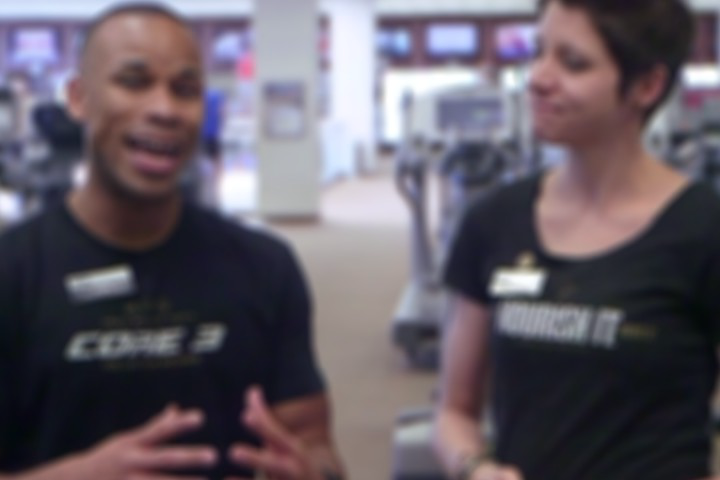

In [21]:
#test the CropRescale transform
im=load_frame(instances[10])
#im = Grayscale(num_output_channels=1)(im)
#im_res = RescaleCrop(crop_size = (480,720), kernel_width=1)(im)
im_res = Multifuz(crop_size = (480,720),
                  kernel_range=(1,16), 
                  quality_range=(90,90), 
                  slope_range=(0.0001, 0.1),
                 radius_range=(.05,.5),
                 scale_range=(1/2,2))(im)
print(im.size,im_res.size)
type(im_res)
im_res

In [22]:


def input_transform(crop_size, kernel_range):
    
    
    return Compose([
        
        Multifuz(crop_size = crop_size,
                  kernel_range=kernel_range, 
                  quality_range=(30,90), 
                  slope_range=(0.00001, 0.01),
                 radius_range=(.05,.75),
                 scale_range=(1/2,2)), 
        #Grayscale(num_output_channels=1),
        ToTensor(),
    ])



def target_transform(crop_size):
    print(crop_size)
    return Compose([
        #Grayscale(num_output_channels=1),
        CenterCrop(crop_size),
        ToTensor(),
    ])



def test_input_transform(crop_size, kernel_size, quality):
    
    return Compose([
        Crappify(crop_size=crop_size, kernel_size=kernel_size, quality=quality),
        ToTensor()
    ])


def get_training_set(data_dir, crop_size, kernel_range, frame_sample_size=10, add_noise=None, 
                     noise_std=3.0,Flip_hor=True,Rand_bright_contrast=True):
    

    cropsize = crop_size
    return DatasetFromVideoFolder(data_dir,crop_size, frame_sample_size,
                             input_transform=input_transform(
                                 crop_size, kernel_range),
                             target_transform=target_transform(crop_size),
                             add_noise=add_noise,
                             noise_std=noise_std,Flip_hor=Flip_hor,
                             Rand_bright_contrast=Rand_bright_contrast)


## Below functions need work

def get_validation_set(data_dir, crop_size, kernel_range):
    
    
    return DatasetFromVideoFolder(data_dir,frame_sample_size,
                             input_transform=input_transform(
                                 cropsize, kernel_range,frame_sample_size=10),
                             target_transform=target_transform(cropsize))


def get_test_set(data_dir, crop_size, kernel_size, quality, frame_sample_size=10):


    return DatasetFromVideoFolder(data_dir,crop_size, frame_sample_size,
                             input_transform=test_input_transform(
                                 crop_size, kernel_size, quality),
                             target_transform=ToTensor(),
                             add_noise=None,
                             noise_std=3,Flip_hor=False,
                             Rand_bright_contrast=False)

In [23]:
train_dir = "/media/SSD/superres/video_data/train_data"
frame_sample_size =10
batch_size = 1 # Make 4 For FP16, 480x720 size images
crop_size = (480,720)
#crop_size = (256,256)
kernel_range=(1,10)
add_noise=False
noise_std=3.0
Flip_hor=True
Rand_bright_contrast=True

In [24]:
# create a data set
# split it using random split
# random_split(range(10), [3, 7], generator=torch.Generator().manual_seed(42))


In [25]:
train_set = get_training_set(data_dir=train_dir, crop_size=crop_size,
            kernel_range=kernel_range,frame_sample_size =frame_sample_size, 
            add_noise=add_noise, noise_std=noise_std,Flip_hor=Flip_hor,Rand_bright_contrast=Rand_bright_contrast)
training_data_loader = DataLoader(dataset=train_set, num_workers=0, batch_size=batch_size, shuffle=True)

(480, 720)


In [26]:
# measurement of blur of an image
def variance_of_laplacian(image):
    # compute the Laplacian of the image and then return the focus
    # measure, which is simply the variance of the Laplacian
    return cv2.Laplacian(image, cv2.CV_64F).var()

In [27]:

def show_batch(dataloader,size = 8):

    inputs, outputs = next(iter(dataloader))
    print(inputs.shape)
    inputs = inputs.numpy().transpose((0, 2, 3, 1))
    outputs = outputs.numpy().transpose((0, 2, 3, 1))
    
    
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inputs = inputs*std + mean
    #outputs = outputs*std + mean
    w,h = 2*size, 4*size
    fig=plt.figure(figsize=(w, h))
    columns = 2
    rows = 4
    ax=[]
    
    for i in range(0, rows):
        blur_measure_input = variance_of_laplacian((inputs[i]*255).astype(np.uint8))
        blur_measure_output = variance_of_laplacian((outputs[i]*255).astype(np.uint8))
        ax.append(fig.add_subplot(rows, columns, 2*i+1))
        ax[-1].set_title('Blur: '+str(blur_measure_input))
        plt.imshow((inputs[i]*255).astype(np.uint8),cmap='gray')
        ax.append(fig.add_subplot(rows, columns, 2*i+2))
        ax[-1].set_title('Blur: '+str(blur_measure_output))
        plt.imshow((outputs[i]*255).astype(np.uint8),cmap='gray')
    plt.show()

torch.Size([1, 3, 480, 720])


IndexError: index 1 is out of bounds for axis 0 with size 1

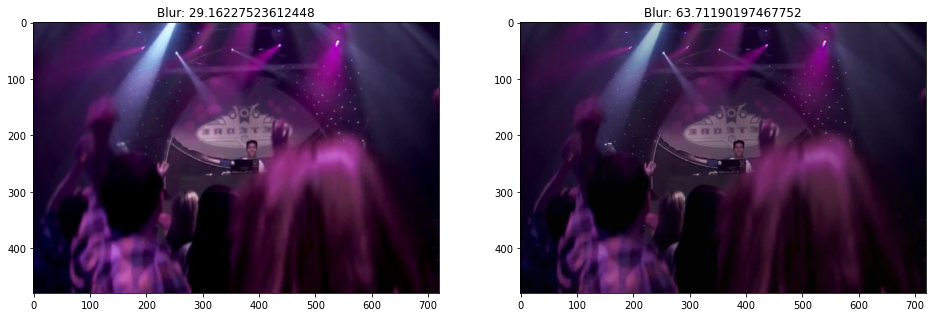

In [28]:
show_batch(training_data_loader,size =8)

In [ ]:
inputs, outputs = next(iter(training_data_loader))

In [ ]:
ToPILImage()(inputs[2])

# EDSR

In [29]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

def default_conv(in_channels, out_channels, kernel_size, bias=True):
    return nn.Conv2d(
        in_channels, out_channels, kernel_size,
        padding=(kernel_size//2), bias=bias)

class MeanShift(nn.Conv2d):
    def __init__(
        self, rgb_range,
        rgb_mean=(0.4488, 0.4371, 0.4040), rgb_std=(1.0, 1.0, 1.0), sign=-1):

        super(MeanShift, self).__init__(3, 3, kernel_size=1)
        std = torch.Tensor(rgb_std)
        self.weight.data = torch.eye(3).view(3, 3, 1, 1) / std.view(3, 1, 1, 1)
        self.bias.data = sign * rgb_range * torch.Tensor(rgb_mean) / std
        for p in self.parameters():
            p.requires_grad = False

class BasicBlock(nn.Sequential):
    def __init__(
        self, conv, in_channels, out_channels, kernel_size, stride=1, bias=False,
        bn=True, act=nn.ReLU(True)):

        m = [conv(in_channels, out_channels, kernel_size, bias=bias)]
        if bn:
            m.append(nn.BatchNorm2d(out_channels))
        if act is not None:
            m.append(act)

        super(BasicBlock, self).__init__(*m)

class ResBlock(nn.Module):
    def __init__(
        self, conv, n_feats, kernel_size,
        bias=True, bn=False, act=nn.ReLU(True), res_scale=1):

        super(ResBlock, self).__init__()
        m = []
        for i in range(2):
            m.append(conv(n_feats, n_feats, kernel_size, bias=bias))
            if bn:
                m.append(nn.BatchNorm2d(n_feats))
            if i == 0:
                m.append(act)

        self.body = nn.Sequential(*m)
        self.res_scale = res_scale

    def forward(self, x):
        res = self.body(x).mul(self.res_scale)
        res += x

        return res

class Upsampler(nn.Sequential):
    def __init__(self, conv, scale, n_feats, bn=False, act=False, bias=True):

        m = []
        if (scale & (scale - 1)) == 0:    # Is scale = 2^n?
            for _ in range(int(math.log(scale, 2))):
                m.append(conv(n_feats, 4 * n_feats, 3, bias))
                m.append(nn.PixelShuffle(2))
                if bn:
                    m.append(nn.BatchNorm2d(n_feats))
                if act == 'relu':
                    m.append(nn.ReLU(True))
                elif act == 'prelu':
                    m.append(nn.PReLU(n_feats))

        elif scale == 3:
            m.append(conv(n_feats, 9 * n_feats, 3, bias))
            m.append(nn.PixelShuffle(3))
            if bn:
                m.append(nn.BatchNorm2d(n_feats))
            if act == 'relu':
                m.append(nn.ReLU(True))
            elif act == 'prelu':
                m.append(nn.PReLU(n_feats))
        else:
            raise NotImplementedError

        super(Upsampler, self).__init__(*m)




url = {
    'r16f64x2': 'https://cv.snu.ac.kr/research/EDSR/models/edsr_baseline_x2-1bc95232.pt',
    'r16f64x3': 'https://cv.snu.ac.kr/research/EDSR/models/edsr_baseline_x3-abf2a44e.pt',
    'r16f64x4': 'https://cv.snu.ac.kr/research/EDSR/models/edsr_baseline_x4-6b446fab.pt',
    'r32f256x2': 'https://cv.snu.ac.kr/research/EDSR/models/edsr_x2-0edfb8a3.pt',
    'r32f256x3': 'https://cv.snu.ac.kr/research/EDSR/models/edsr_x3-ea3ef2c6.pt',
    'r32f256x4': 'https://cv.snu.ac.kr/research/EDSR/models/edsr_x4-4f62e9ef.pt'
}

def make_model(args, parent=False):
    return EDSR(args)

class EDSR(nn.Module):
    def __init__(self, args, conv=default_conv):
        super(EDSR, self).__init__()

        n_resblocks = args.n_resblocks
        n_feats = args.n_feats
        kernel_size = 3 
        scale = args.scale[0]
        act = nn.ReLU(True)
        url_name = 'r{}f{}x{}'.format(n_resblocks, n_feats, scale)
        if url_name in url:
            self.url = url[url_name]
        else:
            self.url = None
        self.sub_mean = MeanShift(args.rgb_range)
        self.add_mean = MeanShift(args.rgb_range, sign=1)

        # define head module
        m_head = [conv(args.n_colors, n_feats, kernel_size)]

        # define body module
        m_body = [
            ResBlock(
                conv, n_feats, kernel_size, act=act, res_scale=args.res_scale
            ) for _ in range(n_resblocks)
        ]
        m_body.append(conv(n_feats, n_feats, kernel_size))

        # define tail module
        m_tail = [
            Upsampler(conv, scale, n_feats, act=False),
            conv(n_feats, args.n_colors, kernel_size)
        ]

        self.head = nn.Sequential(*m_head)
        self.body = nn.Sequential(*m_body)
        self.tail = nn.Sequential(*m_tail)

    def forward(self, x):
        x = self.sub_mean(x)
        x = self.head(x)

        res = self.body(x)
        res += x

        x = self.tail(res)
        x = self.add_mean(x)

        return x 

    def load_state_dict(self, state_dict, strict=True):
        own_state = self.state_dict()
        for name, param in state_dict.items():
            if name in own_state:
                if isinstance(param, nn.Parameter):
                    param = param.data
                try:
                    own_state[name].copy_(param)
                except Exception:
                    if name.find('tail') == -1:
                        raise RuntimeError('While copying the parameter named {}, '
                                           'whose dimensions in the model are {} and '
                                           'whose dimensions in the checkpoint are {}.'
                                           .format(name, own_state[name].size(), param.size()))
            elif strict:
                if name.find('tail') == -1:
                    raise KeyError('unexpected key "{}" in state_dict'
                                   .format(name))

In [30]:
from types import SimpleNamespace

args = SimpleNamespace()

args.n_resgroups = 5 # was 10
args.n_resblocks = 10 # was 20
args.n_feats = 256
args.reduction = 16
args.scale = (1,0)
args.rgb_range = 1.0
args.n_colors = 3
args.res_scale = 0.1

In [31]:
model = EDSR(args)
model.cuda()

EDSR(
  (sub_mean): MeanShift(3, 3, kernel_size=(1, 1), stride=(1, 1))
  (add_mean): MeanShift(3, 3, kernel_size=(1, 1), stride=(1, 1))
  (head): Sequential(
    (0): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (body): Sequential(
    (0): ResBlock(
      (body): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (1): ResBlock(
      (body): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (2): ResBlock(
      (body): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [ ]:
model.load_state_dict(torch.load("/media/SSD/superres/EDSR-PyTorch/EDSR_x2.pt"))

# VDSR with 3 Channel Color

In [ ]:
import torch.nn as nn
from math import sqrt
from functools import partial

class Conv_ReLU_Block(nn.Module):
    def __init__(self,channels=64):
        super(Conv_ReLU_Block, self).__init__()
        self.conv = nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        return self.relu(self.conv(x))
        
class VDSRNet(nn.Module):
    def __init__(self, image_channels=3, blocks=18, feature_channels=64):
        super(VDSRNet, self).__init__()
        self.residual_layer = self.make_layer(partial(Conv_ReLU_Block,channels=feature_channels), blocks)
        self.input = nn.Conv2d(in_channels=image_channels, out_channels=feature_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.output = nn.Conv2d(in_channels=feature_channels, out_channels=image_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
    
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, sqrt(2. / n))
                
    def make_layer(self, block, num_of_layer):
        layers = []
        for _ in range(num_of_layer):
            layers.append(block())
        return nn.Sequential(*layers)

    def forward(self, x):
        residual = x
        out = self.relu(self.input(x))
        out = self.residual_layer(out)
        out = self.output(out)
        out = torch.add(out,residual)
        return out
    
    def forward8(self, x):
        #residual = x
        out = self.relu(self.input(x.float()))
        out = self.residual_layer(out)
        out = self.output(out).int8()
        out = torch.add(out,x).clamp(0,255)
        return out

# VDSR with dropout

In [ ]:
import torch.nn as nn
from math import sqrt

class Conv_ReLU_Block(nn.Module):
    def __init__(self):
        super(Conv_ReLU_Block, self).__init__()
        self.conv = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.do = nn.Dropout2d(p=0.5, inplace=True)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        return self.relu(self.conv(x))
        
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.residual_layer = self.make_layer(Conv_ReLU_Block, 18)
        self.input = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.output = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
    
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, sqrt(2. / n))
                
    def make_layer(self, block, num_of_layer):
        layers = []
        for _ in range(num_of_layer):
            layers.append(block())
        return nn.Sequential(*layers)

    def forward(self, x):
        residual = x
        out = self.relu(self.input(x))
        out = self.residual_layer(out)
        out = self.output(out)
        out = torch.add(out,residual)
        return out
                        


# Build the model

In [ ]:
modelc = VDSRNet(image_channels=3, blocks=18, feature_channels=64)
modelc.cuda()


In [ ]:
modelbw = VDSRNet(image_channels=1, blocks=18, feature_channels=64)
modelbw.cuda()

In [ ]:
#modelbw = torch.load("/media/SSD/superres/pytorch-vdsr/model/model_epoch_50.pth")["model"]

modelbw = torch.load("/media/SSD/superres/checkpoint/percepmodel3_epoch_25.pth")["model"]

In [ ]:
list(dict(modelbw.named_parameters()).keys())

In [ ]:
sbw = dict(modelbw.named_parameters())['residual_layer.17.conv.weight'].data.shape

In [ ]:
sc = dict(modelc.named_parameters())['residual_layer.17.conv.weight'].data.shape

In [ ]:
sbw == sc

In [ ]:
dict(modelc.residual_layer.named_parameters()).keys()

In [ ]:

params_src = modelbw.named_parameters()
params_dest = modelc.named_parameters()

dict_dest = dict(params_dest)
dict_src = dict(modelbw.named_parameters())

for name, param in params_src:

    if name in dict_dest:
        shape_dest = dict_dest[name].data.shape
        shape_src = param.data.shape
        
        
        if shape_dest == shape_src:
            dict_dest[name].data.copy_(param.data)
        else:
            print("name:", name, "source:", shape_src, "dest:", shape_dest)
        

In [ ]:
dict_dest["output.weight"].data[0] = dict_src["output.weight"].data
dict_dest["output.weight"].data[1] = dict_src["output.weight"].data
dict_dest["output.weight"].data[2] = dict_src["output.weight"].data

In [ ]:
#0.299⋅R+0.587⋅G+0.114⋅B


f = dict_src["input.weight"].data.shape[0]
for i in range(0,f):
    dict_dest["input.weight"].data[i,0] = dict_src["input.weight"].data[i,0]*.114
    dict_dest["input.weight"].data[i,1] = dict_src["input.weight"].data[i,0]*.587
    dict_dest["input.weight"].data[i,2] = dict_src["input.weight"].data[i,0]*.299

In [32]:
num_pixels = crop_size[0] * crop_size[1]

In [33]:
class Pixel_Loss(torch.nn.Module):
    
    def __init__(self,num_pixels):
        super(Pixel_Loss,self).__init__()
        self.lossfn = nn.MSELoss(reduction = 'mean')
        self.num_pixels = num_pixels
    def forward(self,x,y):
        
        return self.num_pixels*(self.lossfn.forward(x,y))


In [34]:
criterion = Pixel_Loss(num_pixels)

In [35]:
init_lr = .001
lr_step = 2
gradient_clip = 0.4
epochs = 20

In [36]:
#optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=0.9, weight_decay=1e-4)
optimizer = optim.Adam(model.parameters(), lr=init_lr, weight_decay=1e-4)


In [37]:
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, 
                                          max_lr=0.01,
                                          steps_per_epoch=len(training_data_loader),
                                          epochs=epochs)

In [38]:
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10**0.5 every 3 epochs"""
    lr = init_lr * (0.1 ** (.5*(epoch // lr_step)))
    return lr

In [39]:
def save_checkpoint(experiment, model, epoch):

    model_out_str = str(model_out_path/(model_name_base+"_epoch_{}.pth")).format(epoch)
    
    state = {"experiment": experiment, "epoch": epoch ,"model": model}

    torch.save(state, model_out_str)

    print("Checkpoint saved to {}".format(model_out_str))

In [40]:
import datetime
from torch.cuda.amp import autocast
from torch.cuda.amp import GradScaler
import kornia


In [41]:
from torch.optim.swa_utils import AveragedModel
swa_model = torch.optim.swa_utils.AveragedModel(model)

In [42]:
def trainfp16(training_data_loader, optimizer, scheduler, model, criterion, epoch,scaler):
    dt = str(datetime.datetime.now())
    print("Start Time:", dt)
    
    lr = adjust_learning_rate(optimizer, epoch-1)

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

    print("Epoch = {}, lr = {}".format(epoch, optimizer.param_groups[0]["lr"]))

    model.train()
    cum_loss2=0
    cum_loss = 0
    ct=0
    ct2=0

    for iteration, batch in enumerate(training_data_loader, 1):
        input, target = Variable(batch[0]), Variable(batch[1], requires_grad=False)

        
        input = input.cuda()
        
        target = target.cuda()
        
        optimizer.zero_grad()
        
        # Runs the forward pass with autocasting.
        with autocast():
            output = model(input)
            loss = criterion(output, target)
            
        
        
        
        scaler.scale(loss).backward()
        #loss.backward() 
        
        # Unscales the gradients of optimizer's assigned params in-place
        scaler.unscale_(optimizer)
        
        nn.utils.clip_grad_norm_(model.parameters(),gradient_clip) 
        
        #optimizer.step()
        scaler.step(optimizer)
        
        if epoch>1:
            swa_model.update_parameters(model)
        
        # Updates the scale for next iteration.
        scaler.update()
        
        #scheduler.step()
        
        cum_loss = cum_loss + loss.data
        cum_loss2 = cum_loss2 + loss.data
        ct2=ct2+batch_size
        ct = ct +batch_size
        

        if iteration%10 == 0:
            dt = str(datetime.datetime.now())
            print("===> Time: {} Epoch[{}]({}/{}): LR: {} : Loss: {:.10f}".format(dt,epoch, iteration, len(training_data_loader), optimizer.param_groups[0]["lr"], cum_loss/ct))
            ct=0
            cum_loss =0
   
    print("Epoch Loss:", cum_loss2/ct2)        

In [43]:
# Creates a GradScaler once at the beginning of training for mixed precision
scaler = GradScaler()


for epoch in range(1, epochs+1):
        trainfp16(training_data_loader, optimizer, scheduler, model, criterion, epoch,scaler)
        save_checkpoint(NOTEBOOK_FULL_PATH, model, epoch)

Start Time: 2020-10-08 21:33:06.690946
Epoch = 1, lr = 0.001
===> Time: 2020-10-08 21:33:21.958523 Epoch[1](10/6343): LR: 0.001 : Loss: 67918.4609375000
===> Time: 2020-10-08 21:33:36.887676 Epoch[1](20/6343): LR: 0.001 : Loss: 277968.6875000000
===> Time: 2020-10-08 21:33:52.501846 Epoch[1](30/6343): LR: 0.001 : Loss: 190055.6718750000
===> Time: 2020-10-08 21:34:07.688766 Epoch[1](40/6343): LR: 0.001 : Loss: 16041.8535156250
===> Time: 2020-10-08 21:34:22.777872 Epoch[1](50/6343): LR: 0.001 : Loss: 11447.0380859375
===> Time: 2020-10-08 21:34:38.008163 Epoch[1](60/6343): LR: 0.001 : Loss: 4573.3754882812
===> Time: 2020-10-08 21:34:53.253652 Epoch[1](70/6343): LR: 0.001 : Loss: 4448.7783203125
===> Time: 2020-10-08 21:35:08.626520 Epoch[1](80/6343): LR: 0.001 : Loss: 3267.4365234375
===> Time: 2020-10-08 21:35:24.040597 Epoch[1](90/6343): LR: 0.001 : Loss: 3297.8813476562
===> Time: 2020-10-08 21:35:39.446656 Epoch[1](100/6343): LR: 0.001 : Loss: 4136.0078125000
===> Time: 2020-10-08

===> Time: 2020-10-08 21:55:56.485327 Epoch[1](900/6343): LR: 0.001 : Loss: 2093.5202636719
===> Time: 2020-10-08 21:56:11.381240 Epoch[1](910/6343): LR: 0.001 : Loss: 3654.8132324219
===> Time: 2020-10-08 21:56:26.753820 Epoch[1](920/6343): LR: 0.001 : Loss: 1638.4500732422
===> Time: 2020-10-08 21:56:41.789404 Epoch[1](930/6343): LR: 0.001 : Loss: 1337.7237548828
===> Time: 2020-10-08 21:56:56.581068 Epoch[1](940/6343): LR: 0.001 : Loss: 3208.1323242188
===> Time: 2020-10-08 21:57:11.415895 Epoch[1](950/6343): LR: 0.001 : Loss: 2284.4851074219
===> Time: 2020-10-08 21:57:26.257307 Epoch[1](960/6343): LR: 0.001 : Loss: 3780.0937500000
===> Time: 2020-10-08 21:57:41.151116 Epoch[1](970/6343): LR: 0.001 : Loss: 5474.6713867188
===> Time: 2020-10-08 21:57:56.490060 Epoch[1](980/6343): LR: 0.001 : Loss: 2085.4265136719
===> Time: 2020-10-08 21:58:12.294946 Epoch[1](990/6343): LR: 0.001 : Loss: 2148.9479980469
===> Time: 2020-10-08 21:58:27.194629 Epoch[1](1000/6343): LR: 0.001 : Loss: 184

===> Time: 2020-10-08 22:17:59.233187 Epoch[1](1790/6343): LR: 0.001 : Loss: 2315.0410156250
===> Time: 2020-10-08 22:18:14.072535 Epoch[1](1800/6343): LR: 0.001 : Loss: 1325.7904052734
===> Time: 2020-10-08 22:18:28.946426 Epoch[1](1810/6343): LR: 0.001 : Loss: 1493.6717529297
===> Time: 2020-10-08 22:18:43.608382 Epoch[1](1820/6343): LR: 0.001 : Loss: 2623.6779785156
===> Time: 2020-10-08 22:18:58.369016 Epoch[1](1830/6343): LR: 0.001 : Loss: 1874.1121826172
===> Time: 2020-10-08 22:19:13.081863 Epoch[1](1840/6343): LR: 0.001 : Loss: 16389.1386718750
===> Time: 2020-10-08 22:19:27.809079 Epoch[1](1850/6343): LR: 0.001 : Loss: 3025.0119628906
===> Time: 2020-10-08 22:19:42.605504 Epoch[1](1860/6343): LR: 0.001 : Loss: 3140.4125976562
===> Time: 2020-10-08 22:19:57.365024 Epoch[1](1870/6343): LR: 0.001 : Loss: 1364.1212158203
===> Time: 2020-10-08 22:20:12.150315 Epoch[1](1880/6343): LR: 0.001 : Loss: 1148.5963134766
===> Time: 2020-10-08 22:20:26.868776 Epoch[1](1890/6343): LR: 0.001 

===> Time: 2020-10-08 22:39:52.720893 Epoch[1](2680/6343): LR: 0.001 : Loss: 1244.6879882812
===> Time: 2020-10-08 22:40:07.415639 Epoch[1](2690/6343): LR: 0.001 : Loss: 812.9225463867
===> Time: 2020-10-08 22:40:22.183522 Epoch[1](2700/6343): LR: 0.001 : Loss: 1153.1717529297
===> Time: 2020-10-08 22:40:36.916394 Epoch[1](2710/6343): LR: 0.001 : Loss: 4302.1699218750
===> Time: 2020-10-08 22:40:51.734447 Epoch[1](2720/6343): LR: 0.001 : Loss: 2038.1668701172
===> Time: 2020-10-08 22:41:06.598255 Epoch[1](2730/6343): LR: 0.001 : Loss: 1915.9197998047
===> Time: 2020-10-08 22:41:21.320226 Epoch[1](2740/6343): LR: 0.001 : Loss: 3744.8566894531
===> Time: 2020-10-08 22:41:36.062723 Epoch[1](2750/6343): LR: 0.001 : Loss: 2794.0397949219
===> Time: 2020-10-08 22:41:50.861638 Epoch[1](2760/6343): LR: 0.001 : Loss: 2406.0295410156
===> Time: 2020-10-08 22:42:05.631757 Epoch[1](2770/6343): LR: 0.001 : Loss: 2254.2778320312
===> Time: 2020-10-08 22:42:20.390292 Epoch[1](2780/6343): LR: 0.001 : 

===> Time: 2020-10-08 23:01:44.763003 Epoch[1](3570/6343): LR: 0.001 : Loss: 2543.9272460938
===> Time: 2020-10-08 23:01:59.371111 Epoch[1](3580/6343): LR: 0.001 : Loss: 2116.1682128906
===> Time: 2020-10-08 23:02:14.132085 Epoch[1](3590/6343): LR: 0.001 : Loss: 1395.0214843750
===> Time: 2020-10-08 23:02:28.876534 Epoch[1](3600/6343): LR: 0.001 : Loss: 1214.0455322266
===> Time: 2020-10-08 23:02:43.547931 Epoch[1](3610/6343): LR: 0.001 : Loss: 1155.0175781250
===> Time: 2020-10-08 23:02:58.272490 Epoch[1](3620/6343): LR: 0.001 : Loss: 2385.2717285156
===> Time: 2020-10-08 23:03:13.044771 Epoch[1](3630/6343): LR: 0.001 : Loss: 3590.8188476562
===> Time: 2020-10-08 23:03:27.756877 Epoch[1](3640/6343): LR: 0.001 : Loss: 2936.0434570312
===> Time: 2020-10-08 23:03:42.470173 Epoch[1](3650/6343): LR: 0.001 : Loss: 1966.3455810547
===> Time: 2020-10-08 23:03:57.187327 Epoch[1](3660/6343): LR: 0.001 : Loss: 1854.0770263672
===> Time: 2020-10-08 23:04:11.915570 Epoch[1](3670/6343): LR: 0.001 :

===> Time: 2020-10-08 23:23:36.832616 Epoch[1](4460/6343): LR: 0.001 : Loss: 4308.2509765625
===> Time: 2020-10-08 23:23:51.595365 Epoch[1](4470/6343): LR: 0.001 : Loss: 2251.4555664062
===> Time: 2020-10-08 23:24:06.334794 Epoch[1](4480/6343): LR: 0.001 : Loss: 951.4845581055
===> Time: 2020-10-08 23:24:21.006558 Epoch[1](4490/6343): LR: 0.001 : Loss: 1816.0042724609
===> Time: 2020-10-08 23:24:35.682161 Epoch[1](4500/6343): LR: 0.001 : Loss: 1522.9769287109
===> Time: 2020-10-08 23:24:50.414539 Epoch[1](4510/6343): LR: 0.001 : Loss: 5914.8769531250
===> Time: 2020-10-08 23:25:05.104823 Epoch[1](4520/6343): LR: 0.001 : Loss: 3487.7407226562
===> Time: 2020-10-08 23:25:19.937728 Epoch[1](4530/6343): LR: 0.001 : Loss: 1627.9141845703
===> Time: 2020-10-08 23:25:34.638060 Epoch[1](4540/6343): LR: 0.001 : Loss: 1254.9526367188
===> Time: 2020-10-08 23:25:49.471871 Epoch[1](4550/6343): LR: 0.001 : Loss: 1453.6790771484
===> Time: 2020-10-08 23:26:04.243620 Epoch[1](4560/6343): LR: 0.001 : 

===> Time: 2020-10-08 23:45:28.730508 Epoch[1](5350/6343): LR: 0.001 : Loss: 1643.4992675781
===> Time: 2020-10-08 23:45:43.488423 Epoch[1](5360/6343): LR: 0.001 : Loss: 2299.4152832031
===> Time: 2020-10-08 23:45:58.274614 Epoch[1](5370/6343): LR: 0.001 : Loss: 1343.8742675781
===> Time: 2020-10-08 23:46:12.983770 Epoch[1](5380/6343): LR: 0.001 : Loss: 1587.5681152344
===> Time: 2020-10-08 23:46:27.705000 Epoch[1](5390/6343): LR: 0.001 : Loss: 1109.4619140625
===> Time: 2020-10-08 23:46:42.380315 Epoch[1](5400/6343): LR: 0.001 : Loss: 1034.2116699219
===> Time: 2020-10-08 23:46:57.073041 Epoch[1](5410/6343): LR: 0.001 : Loss: 1039.4406738281
===> Time: 2020-10-08 23:47:11.868726 Epoch[1](5420/6343): LR: 0.001 : Loss: 2291.0615234375
===> Time: 2020-10-08 23:47:26.669134 Epoch[1](5430/6343): LR: 0.001 : Loss: 2303.4453125000
===> Time: 2020-10-08 23:47:41.494560 Epoch[1](5440/6343): LR: 0.001 : Loss: 2521.6020507812
===> Time: 2020-10-08 23:47:56.304946 Epoch[1](5450/6343): LR: 0.001 :

===> Time: 2020-10-09 00:07:20.336090 Epoch[1](6240/6343): LR: 0.001 : Loss: 2047.6575927734
===> Time: 2020-10-09 00:07:35.185423 Epoch[1](6250/6343): LR: 0.001 : Loss: 1627.3801269531
===> Time: 2020-10-09 00:07:49.930822 Epoch[1](6260/6343): LR: 0.001 : Loss: 1452.0673828125
===> Time: 2020-10-09 00:08:04.657878 Epoch[1](6270/6343): LR: 0.001 : Loss: 2702.9802246094
===> Time: 2020-10-09 00:08:19.382055 Epoch[1](6280/6343): LR: 0.001 : Loss: 1803.0946044922
===> Time: 2020-10-09 00:08:34.123196 Epoch[1](6290/6343): LR: 0.001 : Loss: 4713.8256835938
===> Time: 2020-10-09 00:08:48.819765 Epoch[1](6300/6343): LR: 0.001 : Loss: 1132.7426757812
===> Time: 2020-10-09 00:09:03.545870 Epoch[1](6310/6343): LR: 0.001 : Loss: 945.6558837891
===> Time: 2020-10-09 00:09:18.315280 Epoch[1](6320/6343): LR: 0.001 : Loss: 1296.7086181641
===> Time: 2020-10-09 00:09:33.056141 Epoch[1](6330/6343): LR: 0.001 : Loss: 1658.4447021484
===> Time: 2020-10-09 00:09:47.656045 Epoch[1](6340/6343): LR: 0.001 : 

===> Time: 2020-10-09 00:29:04.242322 Epoch[2](780/6343): LR: 0.001 : Loss: 1575.3596191406
===> Time: 2020-10-09 00:29:19.026529 Epoch[2](790/6343): LR: 0.001 : Loss: 1186.1196289062
===> Time: 2020-10-09 00:29:33.863251 Epoch[2](800/6343): LR: 0.001 : Loss: 1261.8745117188
===> Time: 2020-10-09 00:29:48.686993 Epoch[2](810/6343): LR: 0.001 : Loss: 1245.5444335938
===> Time: 2020-10-09 00:30:03.521373 Epoch[2](820/6343): LR: 0.001 : Loss: 1786.7219238281
===> Time: 2020-10-09 00:30:18.316837 Epoch[2](830/6343): LR: 0.001 : Loss: 1285.1541748047
===> Time: 2020-10-09 00:30:33.080748 Epoch[2](840/6343): LR: 0.001 : Loss: 1436.0981445312
===> Time: 2020-10-09 00:30:47.902037 Epoch[2](850/6343): LR: 0.001 : Loss: 1349.7789306641
===> Time: 2020-10-09 00:31:02.684435 Epoch[2](860/6343): LR: 0.001 : Loss: 1112.1258544922
===> Time: 2020-10-09 00:31:17.422495 Epoch[2](870/6343): LR: 0.001 : Loss: 1661.0804443359
===> Time: 2020-10-09 00:31:32.292291 Epoch[2](880/6343): LR: 0.001 : Loss: 1150

===> Time: 2020-10-09 00:51:00.494317 Epoch[2](1670/6343): LR: 0.001 : Loss: 3486.2058105469
===> Time: 2020-10-09 00:51:15.247450 Epoch[2](1680/6343): LR: 0.001 : Loss: 3369.9431152344
===> Time: 2020-10-09 00:51:30.076089 Epoch[2](1690/6343): LR: 0.001 : Loss: 3116.1313476562
===> Time: 2020-10-09 00:51:44.856008 Epoch[2](1700/6343): LR: 0.001 : Loss: 1630.4144287109
===> Time: 2020-10-09 00:51:59.615181 Epoch[2](1710/6343): LR: 0.001 : Loss: 2604.7353515625
===> Time: 2020-10-09 00:52:14.306202 Epoch[2](1720/6343): LR: 0.001 : Loss: 3451.1132812500
===> Time: 2020-10-09 00:52:29.126468 Epoch[2](1730/6343): LR: 0.001 : Loss: 1167.8745117188
===> Time: 2020-10-09 00:52:43.933152 Epoch[2](1740/6343): LR: 0.001 : Loss: 1768.9417724609
===> Time: 2020-10-09 00:52:58.803562 Epoch[2](1750/6343): LR: 0.001 : Loss: 2544.6315917969
===> Time: 2020-10-09 00:53:13.646305 Epoch[2](1760/6343): LR: 0.001 : Loss: 1684.3020019531
===> Time: 2020-10-09 00:53:28.349934 Epoch[2](1770/6343): LR: 0.001 :

===> Time: 2020-10-09 01:12:55.905998 Epoch[2](2560/6343): LR: 0.001 : Loss: 660.9958496094
===> Time: 2020-10-09 01:13:10.736467 Epoch[2](2570/6343): LR: 0.001 : Loss: 1149.6932373047
===> Time: 2020-10-09 01:13:25.467609 Epoch[2](2580/6343): LR: 0.001 : Loss: 975.7365112305
===> Time: 2020-10-09 01:13:40.257354 Epoch[2](2590/6343): LR: 0.001 : Loss: 2539.3107910156
===> Time: 2020-10-09 01:13:54.987077 Epoch[2](2600/6343): LR: 0.001 : Loss: 2875.6872558594
===> Time: 2020-10-09 01:14:09.757887 Epoch[2](2610/6343): LR: 0.001 : Loss: 1605.3272705078
===> Time: 2020-10-09 01:14:24.572362 Epoch[2](2620/6343): LR: 0.001 : Loss: 2689.5241699219
===> Time: 2020-10-09 01:14:39.322557 Epoch[2](2630/6343): LR: 0.001 : Loss: 2247.7722167969
===> Time: 2020-10-09 01:14:54.028117 Epoch[2](2640/6343): LR: 0.001 : Loss: 3087.0930175781
===> Time: 2020-10-09 01:15:08.760208 Epoch[2](2650/6343): LR: 0.001 : Loss: 1436.6610107422
===> Time: 2020-10-09 01:15:23.405253 Epoch[2](2660/6343): LR: 0.001 : L

===> Time: 2020-10-09 01:34:52.083356 Epoch[2](3450/6343): LR: 0.001 : Loss: 2138.1740722656
===> Time: 2020-10-09 01:35:06.885942 Epoch[2](3460/6343): LR: 0.001 : Loss: 1320.8509521484
===> Time: 2020-10-09 01:35:21.703836 Epoch[2](3470/6343): LR: 0.001 : Loss: 965.9850463867
===> Time: 2020-10-09 01:35:36.491763 Epoch[2](3480/6343): LR: 0.001 : Loss: 2518.2939453125
===> Time: 2020-10-09 01:35:51.271865 Epoch[2](3490/6343): LR: 0.001 : Loss: 1819.1331787109
===> Time: 2020-10-09 01:36:06.028335 Epoch[2](3500/6343): LR: 0.001 : Loss: 1172.1103515625
===> Time: 2020-10-09 01:36:20.924523 Epoch[2](3510/6343): LR: 0.001 : Loss: 1611.4615478516
===> Time: 2020-10-09 01:36:35.600187 Epoch[2](3520/6343): LR: 0.001 : Loss: 1759.0828857422
===> Time: 2020-10-09 01:36:50.424648 Epoch[2](3530/6343): LR: 0.001 : Loss: 1123.6763916016
===> Time: 2020-10-09 01:37:05.203753 Epoch[2](3540/6343): LR: 0.001 : Loss: 2036.1226806641
===> Time: 2020-10-09 01:37:20.047175 Epoch[2](3550/6343): LR: 0.001 : 

===> Time: 2020-10-09 01:56:47.399987 Epoch[2](4340/6343): LR: 0.001 : Loss: 2532.6384277344
===> Time: 2020-10-09 01:57:02.068546 Epoch[2](4350/6343): LR: 0.001 : Loss: 1673.1896972656
===> Time: 2020-10-09 01:57:16.960165 Epoch[2](4360/6343): LR: 0.001 : Loss: 1108.7380371094
===> Time: 2020-10-09 01:57:31.675110 Epoch[2](4370/6343): LR: 0.001 : Loss: 1601.9525146484
===> Time: 2020-10-09 01:57:46.445553 Epoch[2](4380/6343): LR: 0.001 : Loss: 1472.9982910156
===> Time: 2020-10-09 01:58:01.251550 Epoch[2](4390/6343): LR: 0.001 : Loss: 1910.2767333984
===> Time: 2020-10-09 01:58:16.009381 Epoch[2](4400/6343): LR: 0.001 : Loss: 1109.2929687500
===> Time: 2020-10-09 01:58:30.790348 Epoch[2](4410/6343): LR: 0.001 : Loss: 1760.5715332031
===> Time: 2020-10-09 01:58:45.649617 Epoch[2](4420/6343): LR: 0.001 : Loss: 2394.9411621094
===> Time: 2020-10-09 01:59:00.359657 Epoch[2](4430/6343): LR: 0.001 : Loss: 2218.5886230469
===> Time: 2020-10-09 01:59:15.224397 Epoch[2](4440/6343): LR: 0.001 :

===> Time: 2020-10-09 02:18:42.846515 Epoch[2](5230/6343): LR: 0.001 : Loss: 3064.3259277344
===> Time: 2020-10-09 02:18:57.635706 Epoch[2](5240/6343): LR: 0.001 : Loss: 2767.2995605469
===> Time: 2020-10-09 02:19:12.466339 Epoch[2](5250/6343): LR: 0.001 : Loss: 1424.8768310547
===> Time: 2020-10-09 02:19:27.281563 Epoch[2](5260/6343): LR: 0.001 : Loss: 2839.3952636719
===> Time: 2020-10-09 02:19:42.029376 Epoch[2](5270/6343): LR: 0.001 : Loss: 3099.7429199219
===> Time: 2020-10-09 02:19:56.828277 Epoch[2](5280/6343): LR: 0.001 : Loss: 2381.4030761719
===> Time: 2020-10-09 02:20:11.591845 Epoch[2](5290/6343): LR: 0.001 : Loss: 1032.2358398438
===> Time: 2020-10-09 02:20:26.340805 Epoch[2](5300/6343): LR: 0.001 : Loss: 3211.3806152344
===> Time: 2020-10-09 02:20:41.229614 Epoch[2](5310/6343): LR: 0.001 : Loss: 1903.7402343750
===> Time: 2020-10-09 02:20:56.003721 Epoch[2](5320/6343): LR: 0.001 : Loss: 1958.9074707031
===> Time: 2020-10-09 02:21:10.754350 Epoch[2](5330/6343): LR: 0.001 :

===> Time: 2020-10-09 02:40:36.626838 Epoch[2](6120/6343): LR: 0.001 : Loss: 4201.7875976562
===> Time: 2020-10-09 02:40:51.330520 Epoch[2](6130/6343): LR: 0.001 : Loss: 2472.5073242188
===> Time: 2020-10-09 02:41:05.962371 Epoch[2](6140/6343): LR: 0.001 : Loss: 2523.9396972656
===> Time: 2020-10-09 02:41:20.777028 Epoch[2](6150/6343): LR: 0.001 : Loss: 2402.3813476562
===> Time: 2020-10-09 02:41:35.605191 Epoch[2](6160/6343): LR: 0.001 : Loss: 2366.9003906250
===> Time: 2020-10-09 02:41:50.392361 Epoch[2](6170/6343): LR: 0.001 : Loss: 1636.3380126953
===> Time: 2020-10-09 02:42:05.210838 Epoch[2](6180/6343): LR: 0.001 : Loss: 1326.4830322266
===> Time: 2020-10-09 02:42:20.020567 Epoch[2](6190/6343): LR: 0.001 : Loss: 1504.5051269531
===> Time: 2020-10-09 02:42:34.881464 Epoch[2](6200/6343): LR: 0.001 : Loss: 1868.5296630859
===> Time: 2020-10-09 02:42:49.673162 Epoch[2](6210/6343): LR: 0.001 : Loss: 1998.8148193359
===> Time: 2020-10-09 02:43:04.434627 Epoch[2](6220/6343): LR: 0.001 :

===> Time: 2020-10-09 02:59:39.172063 Epoch[3](550/6343): LR: 0.00031622776601683794 : Loss: 2487.7475585938
===> Time: 2020-10-09 02:59:53.916601 Epoch[3](560/6343): LR: 0.00031622776601683794 : Loss: 1255.3659667969
===> Time: 2020-10-09 03:00:08.681563 Epoch[3](570/6343): LR: 0.00031622776601683794 : Loss: 972.5987548828
===> Time: 2020-10-09 03:00:23.446701 Epoch[3](580/6343): LR: 0.00031622776601683794 : Loss: 1093.4064941406
===> Time: 2020-10-09 03:00:38.233984 Epoch[3](590/6343): LR: 0.00031622776601683794 : Loss: 824.6150512695
===> Time: 2020-10-09 03:00:52.951919 Epoch[3](600/6343): LR: 0.00031622776601683794 : Loss: 2133.7895507812
===> Time: 2020-10-09 03:01:07.684309 Epoch[3](610/6343): LR: 0.00031622776601683794 : Loss: 1973.9416503906
===> Time: 2020-10-09 03:01:22.328513 Epoch[3](620/6343): LR: 0.00031622776601683794 : Loss: 1378.5404052734
===> Time: 2020-10-09 03:01:37.121566 Epoch[3](630/6343): LR: 0.00031622776601683794 : Loss: 2123.4956054688
===> Time: 2020-10-09

===> Time: 2020-10-09 03:18:21.597684 Epoch[3](1310/6343): LR: 0.00031622776601683794 : Loss: 1812.1170654297
===> Time: 2020-10-09 03:18:36.386523 Epoch[3](1320/6343): LR: 0.00031622776601683794 : Loss: 699.8114624023
===> Time: 2020-10-09 03:18:51.260875 Epoch[3](1330/6343): LR: 0.00031622776601683794 : Loss: 1852.7786865234
===> Time: 2020-10-09 03:19:06.115035 Epoch[3](1340/6343): LR: 0.00031622776601683794 : Loss: 2503.2844238281
===> Time: 2020-10-09 03:19:20.800073 Epoch[3](1350/6343): LR: 0.00031622776601683794 : Loss: 1376.6802978516
===> Time: 2020-10-09 03:19:35.679906 Epoch[3](1360/6343): LR: 0.00031622776601683794 : Loss: 1908.1400146484
===> Time: 2020-10-09 03:19:50.458028 Epoch[3](1370/6343): LR: 0.00031622776601683794 : Loss: 978.3281250000
===> Time: 2020-10-09 03:20:05.209154 Epoch[3](1380/6343): LR: 0.00031622776601683794 : Loss: 1073.5948486328
===> Time: 2020-10-09 03:20:19.942027 Epoch[3](1390/6343): LR: 0.00031622776601683794 : Loss: 1198.0471191406
===> Time: 2

===> Time: 2020-10-09 03:36:49.927196 Epoch[3](2060/6343): LR: 0.00031622776601683794 : Loss: 1272.1103515625
===> Time: 2020-10-09 03:37:04.710195 Epoch[3](2070/6343): LR: 0.00031622776601683794 : Loss: 1392.6265869141
===> Time: 2020-10-09 03:37:19.491660 Epoch[3](2080/6343): LR: 0.00031622776601683794 : Loss: 1077.2857666016
===> Time: 2020-10-09 03:37:34.212148 Epoch[3](2090/6343): LR: 0.00031622776601683794 : Loss: 1850.8143310547
===> Time: 2020-10-09 03:37:48.971534 Epoch[3](2100/6343): LR: 0.00031622776601683794 : Loss: 2109.4387207031
===> Time: 2020-10-09 03:38:03.783901 Epoch[3](2110/6343): LR: 0.00031622776601683794 : Loss: 2484.8735351562
===> Time: 2020-10-09 03:38:18.592708 Epoch[3](2120/6343): LR: 0.00031622776601683794 : Loss: 699.7134399414
===> Time: 2020-10-09 03:38:33.360955 Epoch[3](2130/6343): LR: 0.00031622776601683794 : Loss: 13894.0566406250
===> Time: 2020-10-09 03:38:48.127115 Epoch[3](2140/6343): LR: 0.00031622776601683794 : Loss: 984.9595947266
===> Time: 

===> Time: 2020-10-09 03:55:18.323761 Epoch[3](2810/6343): LR: 0.00031622776601683794 : Loss: 2182.4245605469
===> Time: 2020-10-09 03:55:33.114321 Epoch[3](2820/6343): LR: 0.00031622776601683794 : Loss: 3969.0339355469
===> Time: 2020-10-09 03:55:47.970136 Epoch[3](2830/6343): LR: 0.00031622776601683794 : Loss: 976.9351806641
===> Time: 2020-10-09 03:56:02.802074 Epoch[3](2840/6343): LR: 0.00031622776601683794 : Loss: 1238.6405029297
===> Time: 2020-10-09 03:56:17.524591 Epoch[3](2850/6343): LR: 0.00031622776601683794 : Loss: 2444.0734863281
===> Time: 2020-10-09 03:56:32.291151 Epoch[3](2860/6343): LR: 0.00031622776601683794 : Loss: 3416.6074218750
===> Time: 2020-10-09 03:56:47.163738 Epoch[3](2870/6343): LR: 0.00031622776601683794 : Loss: 1441.4576416016
===> Time: 2020-10-09 03:57:01.987003 Epoch[3](2880/6343): LR: 0.00031622776601683794 : Loss: 1139.0322265625
===> Time: 2020-10-09 03:57:16.777428 Epoch[3](2890/6343): LR: 0.00031622776601683794 : Loss: 1277.5416259766
===> Time: 

===> Time: 2020-10-09 04:13:46.942357 Epoch[3](3560/6343): LR: 0.00031622776601683794 : Loss: 1257.3822021484
===> Time: 2020-10-09 04:14:01.686671 Epoch[3](3570/6343): LR: 0.00031622776601683794 : Loss: 1483.5174560547
===> Time: 2020-10-09 04:14:16.465984 Epoch[3](3580/6343): LR: 0.00031622776601683794 : Loss: 2487.9382324219
===> Time: 2020-10-09 04:14:31.229025 Epoch[3](3590/6343): LR: 0.00031622776601683794 : Loss: 965.2597656250
===> Time: 2020-10-09 04:14:45.971265 Epoch[3](3600/6343): LR: 0.00031622776601683794 : Loss: 971.4841918945
===> Time: 2020-10-09 04:15:00.725129 Epoch[3](3610/6343): LR: 0.00031622776601683794 : Loss: 988.9029541016
===> Time: 2020-10-09 04:15:15.526758 Epoch[3](3620/6343): LR: 0.00031622776601683794 : Loss: 1658.7381591797
===> Time: 2020-10-09 04:15:30.354730 Epoch[3](3630/6343): LR: 0.00031622776601683794 : Loss: 1341.8988037109
===> Time: 2020-10-09 04:15:45.103761 Epoch[3](3640/6343): LR: 0.00031622776601683794 : Loss: 1987.0335693359
===> Time: 20

===> Time: 2020-10-09 04:32:14.961933 Epoch[3](4310/6343): LR: 0.00031622776601683794 : Loss: 1375.7972412109
===> Time: 2020-10-09 04:32:29.697782 Epoch[3](4320/6343): LR: 0.00031622776601683794 : Loss: 1170.2199707031
===> Time: 2020-10-09 04:32:44.504692 Epoch[3](4330/6343): LR: 0.00031622776601683794 : Loss: 1145.3426513672
===> Time: 2020-10-09 04:32:59.345952 Epoch[3](4340/6343): LR: 0.00031622776601683794 : Loss: 2057.5031738281
===> Time: 2020-10-09 04:33:14.135555 Epoch[3](4350/6343): LR: 0.00031622776601683794 : Loss: 1315.8165283203
===> Time: 2020-10-09 04:33:28.952280 Epoch[3](4360/6343): LR: 0.00031622776601683794 : Loss: 2009.7158203125
===> Time: 2020-10-09 04:33:43.731641 Epoch[3](4370/6343): LR: 0.00031622776601683794 : Loss: 806.0860595703
===> Time: 2020-10-09 04:33:58.527487 Epoch[3](4380/6343): LR: 0.00031622776601683794 : Loss: 1149.4282226562
===> Time: 2020-10-09 04:34:13.286757 Epoch[3](4390/6343): LR: 0.00031622776601683794 : Loss: 1327.7043457031
===> Time: 

===> Time: 2020-10-09 04:50:42.769836 Epoch[3](5060/6343): LR: 0.00031622776601683794 : Loss: 1430.8574218750
===> Time: 2020-10-09 04:50:57.499626 Epoch[3](5070/6343): LR: 0.00031622776601683794 : Loss: 445.4960632324
===> Time: 2020-10-09 04:51:12.246177 Epoch[3](5080/6343): LR: 0.00031622776601683794 : Loss: 930.3508911133
===> Time: 2020-10-09 04:51:26.975099 Epoch[3](5090/6343): LR: 0.00031622776601683794 : Loss: 812.3568725586
===> Time: 2020-10-09 04:51:41.749428 Epoch[3](5100/6343): LR: 0.00031622776601683794 : Loss: 792.8363647461
===> Time: 2020-10-09 04:51:56.558670 Epoch[3](5110/6343): LR: 0.00031622776601683794 : Loss: 1029.8739013672
===> Time: 2020-10-09 04:52:11.305502 Epoch[3](5120/6343): LR: 0.00031622776601683794 : Loss: 748.1318359375
===> Time: 2020-10-09 04:52:26.002372 Epoch[3](5130/6343): LR: 0.00031622776601683794 : Loss: 3702.3679199219
===> Time: 2020-10-09 04:52:40.782337 Epoch[3](5140/6343): LR: 0.00031622776601683794 : Loss: 4394.9721679688
===> Time: 2020

===> Time: 2020-10-09 05:09:11.414342 Epoch[3](5810/6343): LR: 0.00031622776601683794 : Loss: 1194.2792968750
===> Time: 2020-10-09 05:09:26.153033 Epoch[3](5820/6343): LR: 0.00031622776601683794 : Loss: 2246.1569824219
===> Time: 2020-10-09 05:09:40.947178 Epoch[3](5830/6343): LR: 0.00031622776601683794 : Loss: 936.0772705078
===> Time: 2020-10-09 05:09:55.707258 Epoch[3](5840/6343): LR: 0.00031622776601683794 : Loss: 1111.5474853516
===> Time: 2020-10-09 05:10:10.386321 Epoch[3](5850/6343): LR: 0.00031622776601683794 : Loss: 1265.7514648438
===> Time: 2020-10-09 05:10:25.081788 Epoch[3](5860/6343): LR: 0.00031622776601683794 : Loss: 2587.3598632812
===> Time: 2020-10-09 05:10:39.893857 Epoch[3](5870/6343): LR: 0.00031622776601683794 : Loss: 1620.1248779297
===> Time: 2020-10-09 05:10:54.607308 Epoch[3](5880/6343): LR: 0.00031622776601683794 : Loss: 3246.4379882812
===> Time: 2020-10-09 05:11:09.417483 Epoch[3](5890/6343): LR: 0.00031622776601683794 : Loss: 910.6809692383
===> Time: 2

===> Time: 2020-10-09 05:27:28.277757 Epoch[4](210/6343): LR: 0.00031622776601683794 : Loss: 1232.6375732422
===> Time: 2020-10-09 05:27:43.125141 Epoch[4](220/6343): LR: 0.00031622776601683794 : Loss: 1210.7678222656
===> Time: 2020-10-09 05:27:57.897184 Epoch[4](230/6343): LR: 0.00031622776601683794 : Loss: 1138.1246337891
===> Time: 2020-10-09 05:28:12.726520 Epoch[4](240/6343): LR: 0.00031622776601683794 : Loss: 2042.1652832031
===> Time: 2020-10-09 05:28:27.459388 Epoch[4](250/6343): LR: 0.00031622776601683794 : Loss: 1458.9681396484
===> Time: 2020-10-09 05:28:42.273299 Epoch[4](260/6343): LR: 0.00031622776601683794 : Loss: 2699.0686035156
===> Time: 2020-10-09 05:28:57.145741 Epoch[4](270/6343): LR: 0.00031622776601683794 : Loss: 2687.5693359375
===> Time: 2020-10-09 05:29:11.879491 Epoch[4](280/6343): LR: 0.00031622776601683794 : Loss: 1196.2204589844
===> Time: 2020-10-09 05:29:26.607331 Epoch[4](290/6343): LR: 0.00031622776601683794 : Loss: 1365.8937988281
===> Time: 2020-10-

===> Time: 2020-10-09 05:46:10.813368 Epoch[4](970/6343): LR: 0.00031622776601683794 : Loss: 727.8360595703
===> Time: 2020-10-09 05:46:25.626791 Epoch[4](980/6343): LR: 0.00031622776601683794 : Loss: 2054.1711425781
===> Time: 2020-10-09 05:46:40.360484 Epoch[4](990/6343): LR: 0.00031622776601683794 : Loss: 1138.7763671875
===> Time: 2020-10-09 05:46:55.123995 Epoch[4](1000/6343): LR: 0.00031622776601683794 : Loss: 980.7615356445
===> Time: 2020-10-09 05:47:09.914157 Epoch[4](1010/6343): LR: 0.00031622776601683794 : Loss: 1100.6420898438
===> Time: 2020-10-09 05:47:24.681444 Epoch[4](1020/6343): LR: 0.00031622776601683794 : Loss: 617.0939331055
===> Time: 2020-10-09 05:47:39.433318 Epoch[4](1030/6343): LR: 0.00031622776601683794 : Loss: 1491.4803466797
===> Time: 2020-10-09 05:47:54.138974 Epoch[4](1040/6343): LR: 0.00031622776601683794 : Loss: 1421.4354248047
===> Time: 2020-10-09 05:48:09.032917 Epoch[4](1050/6343): LR: 0.00031622776601683794 : Loss: 1739.7714843750
===> Time: 2020-

===> Time: 2020-10-09 06:04:39.958199 Epoch[4](1720/6343): LR: 0.00031622776601683794 : Loss: 700.3381347656
===> Time: 2020-10-09 06:04:54.815122 Epoch[4](1730/6343): LR: 0.00031622776601683794 : Loss: 707.8110351562
===> Time: 2020-10-09 06:05:09.613631 Epoch[4](1740/6343): LR: 0.00031622776601683794 : Loss: 2218.7973632812
===> Time: 2020-10-09 06:05:24.402611 Epoch[4](1750/6343): LR: 0.00031622776601683794 : Loss: 1778.9970703125
===> Time: 2020-10-09 06:05:39.195736 Epoch[4](1760/6343): LR: 0.00031622776601683794 : Loss: 1066.3875732422
===> Time: 2020-10-09 06:05:53.956300 Epoch[4](1770/6343): LR: 0.00031622776601683794 : Loss: 1095.5178222656
===> Time: 2020-10-09 06:06:08.786129 Epoch[4](1780/6343): LR: 0.00031622776601683794 : Loss: 908.7749023438
===> Time: 2020-10-09 06:06:23.583208 Epoch[4](1790/6343): LR: 0.00031622776601683794 : Loss: 896.2271728516
===> Time: 2020-10-09 06:06:38.385332 Epoch[4](1800/6343): LR: 0.00031622776601683794 : Loss: 1117.1607666016
===> Time: 202

===> Time: 2020-10-09 06:23:07.779664 Epoch[4](2470/6343): LR: 0.00031622776601683794 : Loss: 1368.7388916016
===> Time: 2020-10-09 06:23:22.548929 Epoch[4](2480/6343): LR: 0.00031622776601683794 : Loss: 3637.1269531250
===> Time: 2020-10-09 06:23:37.284240 Epoch[4](2490/6343): LR: 0.00031622776601683794 : Loss: 694.8185424805
===> Time: 2020-10-09 06:23:52.023136 Epoch[4](2500/6343): LR: 0.00031622776601683794 : Loss: 1019.8101806641
===> Time: 2020-10-09 06:24:06.818403 Epoch[4](2510/6343): LR: 0.00031622776601683794 : Loss: 1812.3695068359
===> Time: 2020-10-09 06:24:21.529903 Epoch[4](2520/6343): LR: 0.00031622776601683794 : Loss: 2407.0075683594
===> Time: 2020-10-09 06:24:36.280105 Epoch[4](2530/6343): LR: 0.00031622776601683794 : Loss: 2023.9351806641
===> Time: 2020-10-09 06:24:50.968968 Epoch[4](2540/6343): LR: 0.00031622776601683794 : Loss: 1921.6484375000
===> Time: 2020-10-09 06:25:05.706542 Epoch[4](2550/6343): LR: 0.00031622776601683794 : Loss: 3202.3415527344
===> Time: 

===> Time: 2020-10-09 06:41:35.756375 Epoch[4](3220/6343): LR: 0.00031622776601683794 : Loss: 426.6258850098
===> Time: 2020-10-09 06:41:50.529386 Epoch[4](3230/6343): LR: 0.00031622776601683794 : Loss: 1876.2933349609
===> Time: 2020-10-09 06:42:05.339774 Epoch[4](3240/6343): LR: 0.00031622776601683794 : Loss: 627.2405395508
===> Time: 2020-10-09 06:42:20.100222 Epoch[4](3250/6343): LR: 0.00031622776601683794 : Loss: 4835.4428710938
===> Time: 2020-10-09 06:42:34.896988 Epoch[4](3260/6343): LR: 0.00031622776601683794 : Loss: 1426.4515380859
===> Time: 2020-10-09 06:42:49.713478 Epoch[4](3270/6343): LR: 0.00031622776601683794 : Loss: 1029.4832763672
===> Time: 2020-10-09 06:43:04.549433 Epoch[4](3280/6343): LR: 0.00031622776601683794 : Loss: 1134.6817626953
===> Time: 2020-10-09 06:43:19.341525 Epoch[4](3290/6343): LR: 0.00031622776601683794 : Loss: 2205.1384277344
===> Time: 2020-10-09 06:43:34.096455 Epoch[4](3300/6343): LR: 0.00031622776601683794 : Loss: 1836.9072265625
===> Time: 2

===> Time: 2020-10-09 07:00:03.596027 Epoch[4](3970/6343): LR: 0.00031622776601683794 : Loss: 1352.1617431641
===> Time: 2020-10-09 07:00:18.393490 Epoch[4](3980/6343): LR: 0.00031622776601683794 : Loss: 9616.5146484375
===> Time: 2020-10-09 07:00:33.111170 Epoch[4](3990/6343): LR: 0.00031622776601683794 : Loss: 852.4052734375
===> Time: 2020-10-09 07:00:47.983394 Epoch[4](4000/6343): LR: 0.00031622776601683794 : Loss: 1158.4403076172
===> Time: 2020-10-09 07:01:02.835025 Epoch[4](4010/6343): LR: 0.00031622776601683794 : Loss: 941.0455932617
===> Time: 2020-10-09 07:01:17.621753 Epoch[4](4020/6343): LR: 0.00031622776601683794 : Loss: 1481.1088867188
===> Time: 2020-10-09 07:01:32.378767 Epoch[4](4030/6343): LR: 0.00031622776601683794 : Loss: 1009.1920166016
===> Time: 2020-10-09 07:01:47.221651 Epoch[4](4040/6343): LR: 0.00031622776601683794 : Loss: 1440.9639892578
===> Time: 2020-10-09 07:02:02.052594 Epoch[4](4050/6343): LR: 0.00031622776601683794 : Loss: 1159.1951904297
===> Time: 2

===> Time: 2020-10-09 07:18:30.940329 Epoch[4](4720/6343): LR: 0.00031622776601683794 : Loss: 823.0950317383
===> Time: 2020-10-09 07:18:45.713977 Epoch[4](4730/6343): LR: 0.00031622776601683794 : Loss: 3826.0004882812
===> Time: 2020-10-09 07:19:00.399527 Epoch[4](4740/6343): LR: 0.00031622776601683794 : Loss: 981.4208374023
===> Time: 2020-10-09 07:19:15.167867 Epoch[4](4750/6343): LR: 0.00031622776601683794 : Loss: 997.2064819336
===> Time: 2020-10-09 07:19:29.936967 Epoch[4](4760/6343): LR: 0.00031622776601683794 : Loss: 1164.5056152344
===> Time: 2020-10-09 07:19:44.699674 Epoch[4](4770/6343): LR: 0.00031622776601683794 : Loss: 704.4664916992
===> Time: 2020-10-09 07:19:59.428275 Epoch[4](4780/6343): LR: 0.00031622776601683794 : Loss: 1461.6451416016
===> Time: 2020-10-09 07:20:14.225816 Epoch[4](4790/6343): LR: 0.00031622776601683794 : Loss: 1033.8752441406
===> Time: 2020-10-09 07:20:28.944671 Epoch[4](4800/6343): LR: 0.00031622776601683794 : Loss: 1623.5233154297
===> Time: 202

===> Time: 2020-10-09 07:36:57.693069 Epoch[4](5470/6343): LR: 0.00031622776601683794 : Loss: 1719.0751953125
===> Time: 2020-10-09 07:37:12.357131 Epoch[4](5480/6343): LR: 0.00031622776601683794 : Loss: 1110.4437255859
===> Time: 2020-10-09 07:37:27.129178 Epoch[4](5490/6343): LR: 0.00031622776601683794 : Loss: 1249.1990966797
===> Time: 2020-10-09 07:37:41.896030 Epoch[4](5500/6343): LR: 0.00031622776601683794 : Loss: 1382.6315917969
===> Time: 2020-10-09 07:37:56.692388 Epoch[4](5510/6343): LR: 0.00031622776601683794 : Loss: 1227.5887451172
===> Time: 2020-10-09 07:38:11.365088 Epoch[4](5520/6343): LR: 0.00031622776601683794 : Loss: 9411.5947265625
===> Time: 2020-10-09 07:38:26.211395 Epoch[4](5530/6343): LR: 0.00031622776601683794 : Loss: 1236.5836181641
===> Time: 2020-10-09 07:38:40.980339 Epoch[4](5540/6343): LR: 0.00031622776601683794 : Loss: 1415.7093505859
===> Time: 2020-10-09 07:38:55.754427 Epoch[4](5550/6343): LR: 0.00031622776601683794 : Loss: 1851.2213134766
===> Time:

===> Time: 2020-10-09 07:55:25.706560 Epoch[4](6220/6343): LR: 0.00031622776601683794 : Loss: 2600.7504882812
===> Time: 2020-10-09 07:55:40.500776 Epoch[4](6230/6343): LR: 0.00031622776601683794 : Loss: 2764.1716308594
===> Time: 2020-10-09 07:55:55.302049 Epoch[4](6240/6343): LR: 0.00031622776601683794 : Loss: 1397.4733886719
===> Time: 2020-10-09 07:56:09.994007 Epoch[4](6250/6343): LR: 0.00031622776601683794 : Loss: 1874.9510498047
===> Time: 2020-10-09 07:56:24.734145 Epoch[4](6260/6343): LR: 0.00031622776601683794 : Loss: 824.7937622070
===> Time: 2020-10-09 07:56:39.469558 Epoch[4](6270/6343): LR: 0.00031622776601683794 : Loss: 1382.4219970703
===> Time: 2020-10-09 07:56:54.201766 Epoch[4](6280/6343): LR: 0.00031622776601683794 : Loss: 1815.7603759766
===> Time: 2020-10-09 07:57:08.962806 Epoch[4](6290/6343): LR: 0.00031622776601683794 : Loss: 6475.1420898438
===> Time: 2020-10-09 07:57:23.794585 Epoch[4](6300/6343): LR: 0.00031622776601683794 : Loss: 1214.5443115234
===> Time: 

===> Time: 2020-10-09 08:16:25.202064 Epoch[5](730/6343): LR: 0.0001 : Loss: 1356.2540283203
===> Time: 2020-10-09 08:16:40.025144 Epoch[5](740/6343): LR: 0.0001 : Loss: 1253.2088623047
===> Time: 2020-10-09 08:16:54.853202 Epoch[5](750/6343): LR: 0.0001 : Loss: 1104.6072998047
===> Time: 2020-10-09 08:17:09.550120 Epoch[5](760/6343): LR: 0.0001 : Loss: 1226.3293457031
===> Time: 2020-10-09 08:17:24.300662 Epoch[5](770/6343): LR: 0.0001 : Loss: 758.0166015625
===> Time: 2020-10-09 08:17:39.007692 Epoch[5](780/6343): LR: 0.0001 : Loss: 1284.8577880859
===> Time: 2020-10-09 08:17:53.813614 Epoch[5](790/6343): LR: 0.0001 : Loss: 1461.2747802734
===> Time: 2020-10-09 08:18:08.480392 Epoch[5](800/6343): LR: 0.0001 : Loss: 689.0143432617
===> Time: 2020-10-09 08:18:23.148705 Epoch[5](810/6343): LR: 0.0001 : Loss: 7061.6416015625
===> Time: 2020-10-09 08:18:37.845017 Epoch[5](820/6343): LR: 0.0001 : Loss: 705.5292358398
===> Time: 2020-10-09 08:18:52.614332 Epoch[5](830/6343): LR: 0.0001 : Lo

===> Time: 2020-10-09 08:38:05.234222 Epoch[5](1610/6343): LR: 0.0001 : Loss: 2109.4978027344
===> Time: 2020-10-09 08:38:20.033314 Epoch[5](1620/6343): LR: 0.0001 : Loss: 1062.6496582031
===> Time: 2020-10-09 08:38:34.682336 Epoch[5](1630/6343): LR: 0.0001 : Loss: 758.1569824219
===> Time: 2020-10-09 08:38:49.490464 Epoch[5](1640/6343): LR: 0.0001 : Loss: 1121.9739990234
===> Time: 2020-10-09 08:39:04.208148 Epoch[5](1650/6343): LR: 0.0001 : Loss: 7177.2485351562
===> Time: 2020-10-09 08:39:19.093123 Epoch[5](1660/6343): LR: 0.0001 : Loss: 910.5554809570
===> Time: 2020-10-09 08:39:33.884602 Epoch[5](1670/6343): LR: 0.0001 : Loss: 2515.4772949219
===> Time: 2020-10-09 08:39:48.659900 Epoch[5](1680/6343): LR: 0.0001 : Loss: 1665.2994384766
===> Time: 2020-10-09 08:40:03.429485 Epoch[5](1690/6343): LR: 0.0001 : Loss: 1123.5111083984
===> Time: 2020-10-09 08:40:18.075277 Epoch[5](1700/6343): LR: 0.0001 : Loss: 913.9840698242
===> Time: 2020-10-09 08:40:32.877794 Epoch[5](1710/6343): LR: 

===> Time: 2020-10-09 08:59:43.746973 Epoch[5](2490/6343): LR: 0.0001 : Loss: 1618.9206542969
===> Time: 2020-10-09 08:59:58.607826 Epoch[5](2500/6343): LR: 0.0001 : Loss: 1281.7967529297
===> Time: 2020-10-09 09:00:13.373572 Epoch[5](2510/6343): LR: 0.0001 : Loss: 903.2796020508
===> Time: 2020-10-09 09:00:28.072465 Epoch[5](2520/6343): LR: 0.0001 : Loss: 662.0940551758
===> Time: 2020-10-09 09:00:42.809429 Epoch[5](2530/6343): LR: 0.0001 : Loss: 2319.6933593750
===> Time: 2020-10-09 09:00:57.598358 Epoch[5](2540/6343): LR: 0.0001 : Loss: 1017.8258666992
===> Time: 2020-10-09 09:01:12.362517 Epoch[5](2550/6343): LR: 0.0001 : Loss: 688.5634765625
===> Time: 2020-10-09 09:01:27.190441 Epoch[5](2560/6343): LR: 0.0001 : Loss: 1355.2065429688
===> Time: 2020-10-09 09:01:41.946979 Epoch[5](2570/6343): LR: 0.0001 : Loss: 1016.4614257812
===> Time: 2020-10-09 09:01:56.728293 Epoch[5](2580/6343): LR: 0.0001 : Loss: 1148.3118896484
===> Time: 2020-10-09 09:02:11.494628 Epoch[5](2590/6343): LR: 

===> Time: 2020-10-09 09:21:23.138400 Epoch[5](3370/6343): LR: 0.0001 : Loss: 1914.5585937500
===> Time: 2020-10-09 09:21:37.897128 Epoch[5](3380/6343): LR: 0.0001 : Loss: 810.4119262695
===> Time: 2020-10-09 09:21:52.670660 Epoch[5](3390/6343): LR: 0.0001 : Loss: 568.6183471680
===> Time: 2020-10-09 09:22:07.474045 Epoch[5](3400/6343): LR: 0.0001 : Loss: 1443.4124755859
===> Time: 2020-10-09 09:22:22.239888 Epoch[5](3410/6343): LR: 0.0001 : Loss: 820.9000244141
===> Time: 2020-10-09 09:22:37.045229 Epoch[5](3420/6343): LR: 0.0001 : Loss: 1675.7508544922
===> Time: 2020-10-09 09:22:51.786257 Epoch[5](3430/6343): LR: 0.0001 : Loss: 2860.5183105469
===> Time: 2020-10-09 09:23:06.510378 Epoch[5](3440/6343): LR: 0.0001 : Loss: 1002.2144775391
===> Time: 2020-10-09 09:23:21.298785 Epoch[5](3450/6343): LR: 0.0001 : Loss: 1260.4373779297
===> Time: 2020-10-09 09:23:36.028656 Epoch[5](3460/6343): LR: 0.0001 : Loss: 1256.6785888672
===> Time: 2020-10-09 09:23:50.842828 Epoch[5](3470/6343): LR: 

===> Time: 2020-10-09 09:43:26.711961 Epoch[5](4250/6343): LR: 0.0001 : Loss: 795.7971191406
===> Time: 2020-10-09 09:43:41.483540 Epoch[5](4260/6343): LR: 0.0001 : Loss: 2456.6318359375
===> Time: 2020-10-09 09:43:56.969805 Epoch[5](4270/6343): LR: 0.0001 : Loss: 750.8092651367
===> Time: 2020-10-09 09:44:12.059331 Epoch[5](4280/6343): LR: 0.0001 : Loss: 644.1979980469
===> Time: 2020-10-09 09:44:27.428376 Epoch[5](4290/6343): LR: 0.0001 : Loss: 988.1362304688
===> Time: 2020-10-09 09:44:42.380459 Epoch[5](4300/6343): LR: 0.0001 : Loss: 1100.8192138672
===> Time: 2020-10-09 09:44:58.003696 Epoch[5](4310/6343): LR: 0.0001 : Loss: 1736.8502197266
===> Time: 2020-10-09 09:45:13.486110 Epoch[5](4320/6343): LR: 0.0001 : Loss: 2177.8386230469
===> Time: 2020-10-09 09:45:29.296468 Epoch[5](4330/6343): LR: 0.0001 : Loss: 639.2185058594
===> Time: 2020-10-09 09:45:44.742025 Epoch[5](4340/6343): LR: 0.0001 : Loss: 2648.6235351562
===> Time: 2020-10-09 09:46:00.511666 Epoch[5](4350/6343): LR: 0.

===> Time: 2020-10-09 10:05:36.667545 Epoch[5](5130/6343): LR: 0.0001 : Loss: 848.9176635742
===> Time: 2020-10-09 10:05:51.524709 Epoch[5](5140/6343): LR: 0.0001 : Loss: 1617.1644287109
===> Time: 2020-10-09 10:06:06.719618 Epoch[5](5150/6343): LR: 0.0001 : Loss: 2038.4361572266
===> Time: 2020-10-09 10:06:21.831114 Epoch[5](5160/6343): LR: 0.0001 : Loss: 3408.5886230469
===> Time: 2020-10-09 10:06:37.013542 Epoch[5](5170/6343): LR: 0.0001 : Loss: 2575.1560058594
===> Time: 2020-10-09 10:06:52.381971 Epoch[5](5180/6343): LR: 0.0001 : Loss: 767.6712646484
===> Time: 2020-10-09 10:07:07.132437 Epoch[5](5190/6343): LR: 0.0001 : Loss: 1096.8487548828
===> Time: 2020-10-09 10:07:21.891443 Epoch[5](5200/6343): LR: 0.0001 : Loss: 1044.8463134766
===> Time: 2020-10-09 10:07:36.621735 Epoch[5](5210/6343): LR: 0.0001 : Loss: 1168.5919189453
===> Time: 2020-10-09 10:07:51.594724 Epoch[5](5220/6343): LR: 0.0001 : Loss: 2425.1389160156
===> Time: 2020-10-09 10:08:07.128097 Epoch[5](5230/6343): LR:

===> Time: 2020-10-09 10:27:28.658078 Epoch[5](6010/6343): LR: 0.0001 : Loss: 834.5658569336
===> Time: 2020-10-09 10:27:43.303183 Epoch[5](6020/6343): LR: 0.0001 : Loss: 3266.5017089844
===> Time: 2020-10-09 10:27:58.055435 Epoch[5](6030/6343): LR: 0.0001 : Loss: 5878.0541992188
===> Time: 2020-10-09 10:28:12.904754 Epoch[5](6040/6343): LR: 0.0001 : Loss: 1142.6525878906
===> Time: 2020-10-09 10:28:27.634857 Epoch[5](6050/6343): LR: 0.0001 : Loss: 1366.0573730469
===> Time: 2020-10-09 10:28:42.546696 Epoch[5](6060/6343): LR: 0.0001 : Loss: 919.1376953125
===> Time: 2020-10-09 10:28:57.406495 Epoch[5](6070/6343): LR: 0.0001 : Loss: 534.9123535156
===> Time: 2020-10-09 10:29:12.144404 Epoch[5](6080/6343): LR: 0.0001 : Loss: 2801.6462402344
===> Time: 2020-10-09 10:29:26.860066 Epoch[5](6090/6343): LR: 0.0001 : Loss: 1323.7847900391
===> Time: 2020-10-09 10:29:41.684198 Epoch[5](6100/6343): LR: 0.0001 : Loss: 1035.3546142578
===> Time: 2020-10-09 10:29:56.406086 Epoch[5](6110/6343): LR: 

===> Time: 2020-10-09 10:48:57.055966 Epoch[6](540/6343): LR: 0.0001 : Loss: 1792.7371826172
===> Time: 2020-10-09 10:49:11.820160 Epoch[6](550/6343): LR: 0.0001 : Loss: 1507.5600585938
===> Time: 2020-10-09 10:49:26.544843 Epoch[6](560/6343): LR: 0.0001 : Loss: 2335.4199218750
===> Time: 2020-10-09 10:49:41.290675 Epoch[6](570/6343): LR: 0.0001 : Loss: 810.9199218750
===> Time: 2020-10-09 10:49:56.015977 Epoch[6](580/6343): LR: 0.0001 : Loss: 991.6923217773
===> Time: 2020-10-09 10:50:10.821875 Epoch[6](590/6343): LR: 0.0001 : Loss: 1496.3626708984
===> Time: 2020-10-09 10:50:25.554371 Epoch[6](600/6343): LR: 0.0001 : Loss: 1719.1409912109
===> Time: 2020-10-09 10:50:40.365705 Epoch[6](610/6343): LR: 0.0001 : Loss: 1017.0082397461
===> Time: 2020-10-09 10:50:55.128263 Epoch[6](620/6343): LR: 0.0001 : Loss: 1498.0452880859
===> Time: 2020-10-09 10:51:09.950801 Epoch[6](630/6343): LR: 0.0001 : Loss: 1023.0173950195
===> Time: 2020-10-09 10:51:24.684178 Epoch[6](640/6343): LR: 0.0001 : L

KeyboardInterrupt: 

Function that takes in a .mp4 video file and applies intrinsic matrix and distortion coefficients to undistort a video.  It also preserves the sound. it uses ffmpeg for some processing as well as opencv cv2 library.

In [44]:
# Define the colorization function
# We'll reuse the Cb and Cr channels from bicubic interpolation
def colorize_cv(y, ycbcr): 
    img = np.zeros((y.shape[0], y.shape[1], 3), np.uint8)
    img[:,:,0] = y
    img[:,:,1] = ycbcr[:,:,1]
    img[:,:,2] = ycbcr[:,:,2]
    img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)
    return img

In [45]:
def decolorize_cv(frame):
    im_ycbcr = cv2.cvtColor(frame, cv2.COLOR_BGR2YCR_CB)
    im_b_y = im_ycbcr[:,:,0].astype(float)
    im_grey = im_b_y/255.0
    return im_grey, im_ycbcr

In [46]:
from torch.cuda.amp import autocast
def superres_mp4(infile, outfile, model,channels=1, factor=1.0,display=True,bitrate= "12000k",errorfile = None):
    
    model = model.cuda()
    #torch.set_grad_enabled(False)
    #model.eval()
    
    cap = cv2.VideoCapture(str(infile))
    
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps    = cap.get(cv2.CAP_PROP_FPS)
    
    success_flag = False
    
    print("Original File:", str(infile))
    print("frames=",length,"\nwidth=",width,"\nheight=",height,"\nfps=",fps)
    
    

    new_height = int(height*factor)
    new_width = int(width*factor)
    
    print("\nProcess File:", str(outfile))
    print("factor:",factor,"\nwidth=",new_width, "\nheight=",new_height,"\nbitrate=",bitrate)
    
    

    dimension = '{}x{}'.format(new_width, new_height)  #ffmpeg uses bicubic as default scaling alg
    f_format = 'bgr24' # remember OpenCV uses bgr format




    command = ['ffmpeg',
            '-y',
            '-f', 'rawvideo',
            '-vcodec','rawvideo',
            '-s', dimension,
            '-pix_fmt', 'bgr24',
            '-r', str(fps),
            '-i', '-',
            '-i', str(infile),
            '-c:v', 'h264',
            '-c:a', 'aac',

            '-map','0:v:0',
            '-map','1:a:0',
            '-shortest',
            '-b:v', bitrate, 
            str(outfile) ]


    if errorfile is not None:
        ef = open(error_file,"w+")
        p = sp.Popen(command, stdin=sp.PIPE, stderr=ef)
    else:
        p = sp.Popen(command, stdin=sp.PIPE)

    # Full processing with a stream instead of a temp file for video
    pbar = tqdm(total=length)
    while(cap.isOpened()):




        # Capture frame-by-frame
        ret, frame = cap.read()
        if ret == True:
            
            if (factor != 1.0):
                frame = cv2.resize(frame, (new_width, new_height), interpolation=cv2.INTER_LANCZOS4)
            
            if channels == 1:
                im_input, im_b_ycbcr = decolorize_cv(frame)

                im_input = Variable(torch.from_numpy(im_input).float()).view(1, -1, im_input.shape[0], im_input.shape[1])
                im_input = im_input.cuda()

                with autocast():
                    out = model(im_input)
                out = (out*255.0).clamp(0,255)

                out = out.cpu()

                im_h_y = out.data[0].numpy().astype(np.float32)

                im_h_y = im_h_y[0,:,:]

                im_h = colorize_cv(im_h_y, im_b_ycbcr)
            elif channels == 3:
                im_input = frame/255.
                im_input = Variable(torch.from_numpy(im_input).float()).\
                view(1, 3, im_input.shape[0], im_input.shape[1])
        
  
                im_input = im_input.cuda()
    
                
                
                with autocast():
                    out = model(im_input)
                out = (out*255.0).clamp(0,255)

                out = out.cpu()
                
                im_h = out.data[0].view(im_input.shape[2], im_input.shape[3],3).numpy().astype(np.uint8)

                #im_h = out.data[0].numpy().astype(np.float32)

            
                

            p.stdin.write(im_h.tobytes())


            if display:
                cv2.imshow('Processed',im_h)
                time.sleep(10)
                #cv2.imshow('Orig',frame)
            pbar.update(1)
            # Press Q on keyboard to  exit
            if cv2.waitKey(25) & 0xFF == ord('q'):
                success_flag = False
                break
        # Break the loop
        else:
            success_flag = True
            break
    # When everything done, release the video capture object

    pbar.close()

    p.stdin.close()
    p.wait()

    cap.release()

    # Closes all the frames
    cv2.destroyAllWindows()
    
    return success_flag

# compare to benchmarks

In [47]:
from PIL import Image
import math
import matplotlib.pyplot as plt

In [48]:
# Here is the function for PSNR calculation
def PSNR(pred, gt, shave_border=0):
    height, width = pred.shape[:2]
    pred = pred[shave_border:height - shave_border, shave_border:width - shave_border]
    gt = gt[shave_border:height - shave_border, shave_border:width - shave_border]
    imdff = pred - gt
    rmse = math.sqrt(np.mean(imdff ** 2))
    if rmse == 0:
        return 100
    return 20 * math.log10(255.0 / rmse)

In [49]:
# Define the colorization function
# We'll reuse the Cb and Cr channels from bicubic interpolation
def colorize(y, ycbcr): 
    img = np.zeros((y.shape[0], y.shape[1], 3), np.uint8)
    img[:,:,0] = y
    img[:,:,1] = ycbcr[:,:,1]
    img[:,:,2] = ycbcr[:,:,2]
    img = Image.fromarray(img, "YCbCr").convert("RGB")
    return img

In [50]:
def decolorize(x):
    x_ycbcr = cv2.cvtColor(x, cv2.COLOR_BGR2YCR_CB)
    x_y = x_ycbcr[:,:,0].astype(float)
    return x_y, x_ycbcr

In [65]:
def display_PSNR(im_gt, im_b, im_in, model,channels=1, display=True):
    

    # Convert the images into YCbCr mode and extraction the Y channel (for PSNR calculation)
    im_gt_ycbcr = np.array(im_gt.convert("YCbCr"))
    im_b_ycbcr = np.array(im_b.convert("YCbCr"))
    im_in_ycbcr = np.array(im_in.convert("YCbCr"))
    
    im_gt_y = im_gt_ycbcr[:,:,0].astype(float)
    im_b_y = im_b_ycbcr[:,:,0].astype(float)
    im_in_y = im_in_ycbcr[:,:,0].astype(float)
    
    #psnr_bicubic = PSNR(im_gt_y, im_b_y)
    #psnr_input = PSNR(im_gt_y, im_in_y)
    psnr_bicubic = PSNR(np.array(im_gt),np.array( im_b))
    psnr_input = PSNR(np.array(im_gt), np.array(im_in))
    
    im_i_ycbcr = np.array(im_in.convert("YCbCr"))
    im_i_y = im_i_ycbcr[:,:,0].astype(float)
        
    # Prepare for the input, a pytorch tensor
    if channels == 1:
        im_input = im_i_y/255.
        im_input = Variable(torch.from_numpy(im_input).float()).\
        view(1, -1, im_input.shape[0], im_input.shape[1])
    
    if channels ==3:
        im_input = np.array(im_in)/255.0
        #im_input = np.array(im_in)
        im_input = Variable(torch.from_numpy(im_input).float()).\
        view(1, 3, im_input.shape[0], im_input.shape[1])
        
    #print("im_input.shape=",im_input.shape)    
    im_input = im_input.cuda()
    
    with autocast():
        out = model(im_input)
    
    out = (out*255.0).clamp(0,255)
    
    out = out.cpu()
    
    if channels == 1:
        im_y = out.data[0].numpy().astype(np.float32)
        im_h_y = im_y[0,:,:]
        im_h = np.array(colorize(im_h_y, im_b_ycbcr))

    elif channels ==3:
        #print("out[0]=",out[0].shape)
        #print("out.data[0]=",out.data[0].shape)
        #print("im_input.shape=",im_input.shape)
        im_h = out.data[0].view(im_input.shape[2], im_input.shape[3],3).numpy().astype(np.uint8)
        #print("im.h.shape=",im_h.shape)
        im_h_y, _ = decolorize(im_h)
        
    
    # Calculate the PNSR for prediction
    #psnr_predicted = PSNR(im_gt_y, im_h_y)
    psnr_predicted = PSNR(np.array(im_gt), np.array(im_h))
    
    
    # Calculate the PNSR different between bicubic interpolation and vdsr prediction
    
    
    
    blur_measure_gt = variance_of_laplacian((im_gt_y).astype(np.uint8))
    blur_measure_bicubic = variance_of_laplacian((im_b_y).astype(np.uint8))
    blur_measure_input = variance_of_laplacian((im_i_y).astype(np.uint8))
    blur_measure_vdsr = variance_of_laplacian((im_h_y).astype(np.uint8))
    
    
    
    # Colorize the grey-level image and convert into RGB mode

    im_gt = Image.fromarray(im_gt_ycbcr, "YCbCr").convert("RGB")
    im_b = Image.fromarray(im_b_ycbcr, "YCbCr").convert("RGB")
    
    if display:
    
        print('psnr for bicubic is {}dB'.format(psnr_bicubic))
        print('psnr for input is {}dB'.format(psnr_input))
        
        print('psnr for Model is {}dB'.format(psnr_predicted))
        print("PSNR improvement is {}dB".format(psnr_predicted - psnr_input))

        print("Sharpness Measurement GroundTruth:",blur_measure_gt)
        print("Sharpness Measurement Bicubic:",blur_measure_bicubic)
        print("Sharpness Measurement Input:",blur_measure_input)
        print("Sharpness Measurement Model:",blur_measure_vdsr)

        # Result visualization
        fig = plt.figure(figsize=(18, 16), dpi= 80)
        ax = plt.subplot(151)
        ax.imshow(im_gt)
        ax.set_title("GT")

        ax = plt.subplot(152)
        ax.imshow(im_b)
        ax.set_title("Bicubic")

        ax = plt.subplot(153)
        ax.imshow(im_in)
        ax.set_title("Input")

        ax = plt.subplot(154)
        ax.imshow(im_h)
        ax.set_title("Output(Model)")
        
        
        ax = plt.subplot(155)
        ax.imshow(np.clip(im_h-im_in +128,0,255))
        ax.set_title("Model-Input")
        plt.show()
    
    return im_h, psnr_bicubic, psnr_predicted

In [66]:
model = torch.load("/media/SSD/superres/checkpoint/EDSR_epoch_5.pth")["model"]

In [71]:
# Load the groundtruth image and the low-resolution image (downscaled with a factor of 4)
im_gt = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/butterfly_GT.bmp").convert("RGB")
im_b = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/butterfly_GT_scale_4.bmp").convert("RGB")
im_b2 = CropRescale(crop_size = 256, factor_range=(4,4))(im_gt)

psnr for bicubic is 30.222371136419135dB
psnr for input is 29.17515403965874dB
psnr for Model is 27.813140731500226dB
PSNR improvement is -1.362013308158513dB
Sharpness Measurement GroundTruth: 2236.2222292274237
Sharpness Measurement Bicubic: 68.66161937173456
Sharpness Measurement Input: 37.15947355306707
Sharpness Measurement Model: 40.159753050422296


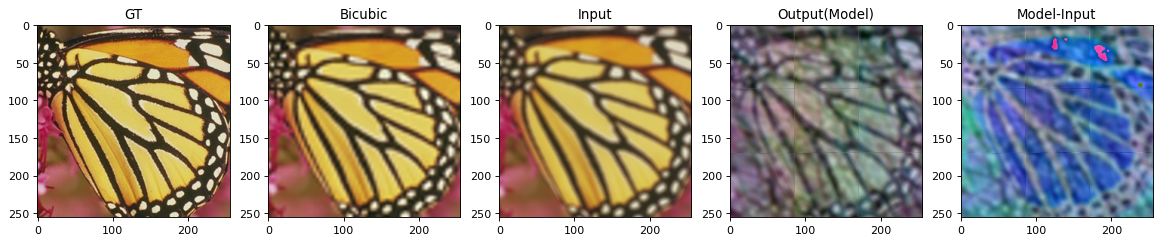

In [72]:
display_PSNR(im_gt, im_b, im_b2, model, channels=3);


In [ ]:
im_gt.size

In [ ]:
# Make this load still photos too, and have them added with frame = 0
def test_results(test_dir,scale, channels=1, display = False):
    instances = []
    psnr_bicubic_sum = 0
    psnr_model_sum = 0
    ct = 0
    
    for filename in listdir(test_dir):
        filepath = os.path.join(test_dir,filename)
        #print(filepath)
                
        if is_image_file(filepath):
            im_gt = Image.open(filepath).convert("RGB")
            #print(im_gt.size)
            
            (height, width) = im_gt.size
            im_b = im_gt.resize((int(height/scale), int(width/scale)), resample = Image.BICUBIC)
            im_b = im_b.resize((height,width), resample = Image.BICUBIC)
            im_b2 = Crappify(crop_size = None, kernel_size=scale*2, quality=90)(im_gt)# open image file
            im_h, psnr_bicubic, psnr_predicted = display_PSNR(im_gt, im_b, im_b2, model, channels=channels, display = display)
            psnr_bicubic_sum = psnr_bicubic_sum + psnr_bicubic
            psnr_model_sum = psnr_model_sum + psnr_predicted
            ct = ct +1
            #item = {"Filepath":filepath, "Type":"image"}
            #instances.append(item)
        
    psnr_bicubic_avg = psnr_bicubic_sum / ct
    psnr_model_avg = psnr_model_sum / ct
        
    print("Bicubic average PSNR =",psnr_bicubic_avg)
    print("Model average PSNR =",psnr_model_avg)
    return 



In [ ]:
test_results("/media/SSD/superres/video_data/test_data/Set5", 8, channels = 3,display = True)

# convert sample videos

In [ ]:
result_path

In [ ]:
folder = "/media/SSD/superres/Results/Superresolution train vdsr with hres perception loss multifuz/"

infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = result_path/"muffins30sec-16.mp4"
superres_mp4(infile, outfile, model,channels=3, factor=1.6,display=False,bitrate= "4000k")

In [ ]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = result_path/"muffins30sec-10.mp4"
superres_mp4(infile, outfile, model,channels=1, factor=1.0,display=False,bitrate= "4000k")

In [ ]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = result_path/"muffins30sec-20.mp4"
superres_mp4(infile, outfile, model,channels=3, factor=2.0,display=False,bitrate= "4000k")

In [ ]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = result_path/"muffins30sec-30.mp4"
superres_mp4(infile, outfile, model,channels=3, factor=3.0,display=False,bitrate= "4000k")


In [ ]:
dualfile= str(result_path/"muffins30sec-30dual.mp4")
infile = str(infile)
outfile = str(outfile)

In [ ]:
# double scale for video x3 2 min
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -t 120 -filter_complex "[0:v] scale=iw*2:ih*2, pad=2*iw:ih [left]; [1:v] scale=iw/1.5:ih/1.5 [right]; [left][right] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

In [ ]:
# original scale , for video x3
#!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v] scale=iw*1:ih*1, pad=2*iw:ih [left]; [1:v] scale=iw/3:ih/3 [right]; [left][right] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

In [ ]:
infile = "/media/SSD/superres/super8/super8_best_from_mp2.mp4"
outfile = result_path/"super8.mp4"
error_file = "/media/SSD/superres/error.txt"
superres_mp4(infile, outfile, model,channels=3, factor=1.0,display=False,bitrate= "4000k",errorfile = error_file)

In [ ]:

dualfile = str(result_path/"super8dual.mp4")
infile = str(infile)
outfile = str(outfile)

In [ ]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

In [ ]:
# compare this model to the last one
infile = "/media/SSD/superres/Results/Superresolution train espcn with hres perception loss multifuz/super8hespcn1.mp4"
outfile = str(result_path/"super8.mp4")
dualfile= str(result_path/"super8-tolast-dual.mp4")

In [ ]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

In [ ]:
infile = "/media/SSD/superres/super8/Old 8mm Reels_1.mp4"
outfile = result_file/"super8long.mp4"
error_file = "/media/SSD/superres/error.txt"
superres_mp4(infile, outfile, model,channels=3, factor=1.0,display=False,bitrate= "4000k",errorfile = error_file)

In [ ]:
dualfile= folder + "super8longdual.mp4"
infile = str(infile)
outfile = str(outfile)

In [ ]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}